## Integrantes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from scipy.stats import mstats
import warnings; warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)
sns.set_theme()


In [2]:
file_name = 'diabetes_proyecto.csv'
df = pd.read_csv(file_name)

# EDA

* Tamaño del dataset

In [ ]:
print(df.shape)

In [ ]:
print(df.head())

In [ ]:
print(df.info())

* Variables numericas: Pregnancies, Glucose, BloodPressure, SkinThickness, BMI, DiabetesPedigreeFunction,  Insulin, Age, Outcome y StressLevel.
* Variables categoricas: LifeStyle, DietType, SmokinStatus y FamilyHistory.
* Variable objetivo: Outcome -  0:Paciente NO tiene diabetes 1: Paciente SI tiene diabetes.

In [ ]:
print(df.describe())

* La mayoria de mujeres ha tenido entre 1 y 6 embarazos, con casos extremos de hasta 17.
* Respecto a la glucosa en sangre obtenemos una media de 120 y un rango intercuartilico entre 99 y 141 con un maximo de 199 lo cual parece muy razonable.
* Para la presion arterial tenemos un promedio de 69 lo cual medicamente esta dentro de lol normal.
* Para espesor de piel obtenemos un promedio bajo de 20 lo cual representa grasa corporal.
* En la variable insulina encontramos que es muy variable porque da un promedio de 80 pero con casos extremos de hasta 846.
* Indice de masa corporal tiene un promedio de 32 lo que indicaria un alto riesgo metabolico asociado al peso porque corresponde a obesidad de grado I.
* Antecedentes geneticos de diabetes nos indica un riesgo en promedio bajo de 0.47.
* El promedio de la edad de las personas incluidas en la muestra.
* con el Diagnostico de diabetes observamos que solo el 20% de las mujeres tienen diabetes diagnosticada.
* Obtenemos un nivel de estres promedio de 5 pero algunos datos son negativos lo que no tiene sentido.
* Tenemos unas variables que tienen ceros como datos y esto no tiene sentido si lo aterrizamos a la realidad como: Glucose, BloodPressure, SkinThckness, Insulin Y BMI. Hay que tener en cuenta que al ser ceros sin sentido probablemente fueron datos que no se tomaron y seria mejor manejarlos como datos faltantes. 

In [ ]:
print(df.isnull().sum())

* Observamos que tenemos datos faltantes en las variables Glucose, Insuline y Stresslevel.

In [ ]:
missing_pct = df.isnull().mean()*100
print(missing_pct)

* Al tener en ciertas variables con entre 1% y 5% de datos faltantes en un caso de una base de datos con datos clinicos, la mejor opcion NO es eliminar las filas con datos faltantes porque podemos perder informacion importante.
* De esta manera mas adelante se explicara de que manera se decidio manejar esos datos faltantes.

### Balance de clases

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x="Outcome", hue="Outcome", data=df, palette="pastel", legend=False)
plt.title("Balance de clases en Outcome")
plt.show()

print(df["Outcome"].value_counts(normalize=True)*100)

* El 79.9% de los registros corresponden a pacientes no diabeticos.
* 20% de loss registros corresponden a pacientes diabeticos.
* Esto indica un fuerte desbalance de clases.
* Por lo tanto sabemos que el dataset tiene 4 veces mas pacientes sanos que con diabetes, este desbalance muestra como en la poblacion general suele ser menor las personas con diabetes que con diabetes.
* Es necesario corregir esto porque sino se hace los modelos predictivos van a tender a "favorecer" la clase mayoritaria que en este caso son los no biabeticos.

### Distribución de variables numericas

In [ ]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(12, 5))
    
    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    
    plt.show()


Pregnancies:

* Qué muestra: Distribución y boxplot de embarazos.
* Hallazgo: La mayoría entre 0–5; algunos outliers >12.
* Interpretación: Distribución sesgada a la derecha.
* Implicación: Puede requerir tratamiento de outliers.
* Limitación: Variable discreta y no normal.


Glucose:

* Qué muestra: Niveles de glucosa.
* Hallazgo: Centro en 100–125; outliers cerca de 0 y >180.
* Interpretación: Valores bajos pueden ser errores; altos reflejan hiperglucemia.
* Implicación: Variable clave para el diagnóstico.
* Limitación: Revisar valores extremos.

BloodPressure

* Qué muestra: Presión arterial.
* Hallazgo: Mayoría 60–85; outliers en 0 y >120.
* Interpretación: Ceros poco realistas → datos faltantes.
* Implicación: Requiere limpieza o imputación.
* Limitación: Influida por factores externos no controlado

SkinThickness

* Qué muestra: Pliegue cutáneo.
* Hallazgo: Muchos valores en 0; moda alrededor de 30.
* Interpretación: Ceros son datos faltantes más que reales.
* Implicación: Requiere imputación antes del modelado.
* Limitación: Medición sensible al observador.

Insulin

* Qué muestra: Niveles de insulina.
* Hallazgo: Distribución sesgada, gran cantidad de ceros y outliers >600.
* Interpretación: Ceros posiblemente datos faltantes; dispersión alta refleja variabilidad metabólica.
* Implicación: Necesario limpiar o transformar la variable.
* Limitación: Alta varianza interindividual.

DiabetesPedigreeFunction

* Qué muestra: Riesgo hereditario de diabetes.
* Hallazgo: Distribución sesgada, mayoría <1, algunos outliers >2.
* Interpretación: Captura historial familiar, pero con gran asimetría.
* Implicación: Útil para modelar riesgo genético.
* Limitación: Basado en autorreporte → posible sesgo.

Age

* Qué muestra: Edad de los pacientes.
* Hallazgo: Sesgo hacia adultos jóvenes (20–40 años); algunos outliers >70.
* Interpretación: Mayoría de la muestra es población joven; casos mayores son menos frecuentes pero relevantes.
* Implicación: La edad puede ser predictor de riesgo creciente de diabetes.
* Limitación: No captura estilo de vida asociado a cada rango etario.

Outcome

* Qué muestra: Variable objetivo (0 = no diabetes, 1 = diabetes).
* Hallazgo: Distribución desbalanceada, más clase 0 que clase 1.
* Interpretación: La mayoría de los pacientes no son diabéticos.
* Implicación: El modelo requerirá técnicas de balanceo (SMOTE, pesos).
* Limitación: Desequilibrio puede afectar la sensibilidad del modelo.


StressLevel

* Qué muestra: Nivel de estrés.
*  Hallazgo: Distribución casi normal centrada en 6–7; algunos outliers extremos.
* Interpretación: Estrés podría relacionarse con estilo de vida y predisposición a diabetes.
* Implicación: Potencial variable explicativa si interactúa con BMI o Glucosa.
* Limitación: Basado en autorreporte → subjetivo y variable según contexto.


### Outliers

In [ ]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

* Como se puede observar las variables con mas outliers relevantes son BloodPressure, Insulim, BMI y DiabetesPedigreeFunction, por lo tanto necesitan un tratamiento especifico.
* Mientras que los outliers que se presentan en las variables Pregnancies o SkinThickness los outliers no son muy criticos.
* Alguno outliers presentan casos clinicos posibles mientras que otros parecen errores de captura como presion arterial en cero.

### Relaciones de las variables con la variable objetivo

In [ ]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Outcome", y=col, hue="Outcome", data=df, palette="pastel", dodge=False, legend=False)
    plt.title(f"{col} vs Outcome")
    plt.show()



Análisis conjunto de variables vs Outcome:

* Qué muestra:
Se analizaron las variables clínicas y de estilo de vida del dataset de diabetes, comparadas contra la variable objetivo Outcome, utilizando boxplots.

* Hallazgo principal:
Las variables Glucose, BMI y Age muestran mayor separación entre grupos, indicando fuerte asociación con el Outcome. Por lo tanto las variables BloodPressure, SkinThickness y StressLevel presentan poca diferencia entre clases.

* Interpretación:
La glucosa es la que mejor distingue entre personas con y sin diabetes. El IMC y la edad también influyen como factores de riesgo, mientras que otras variables como Insulin, DPF, BloodPressure o SkinThickness aportan menos información por sí solas.

* Implicación:
El modelo predictivo deberia priorizar Glucose, BMI y Age como features principales. Variables menos relevantes pueden ser útiles, pero su efecto aislado es limitado. Podría ser necesario aplicar balanceo de clases y ajustar umbrales de decisión para optimizar sensibilidad en la detección de casos positivos.

* Limitaciones: 
El análisis de una variable por separado no muestra cómo se relacionan entre ellas. Además, los valores atípicos y la gran variación en variables como Insulin o DPF pueden afectar los resultados. Por eso es necesario usar validación cruzada para evitar sobreajuste y asegurar que el modelo funcione bien en distintos casos.

### Correlacion entre variables

In [ ]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones")
plt.show()

* Que muestra:
Matriz de correlaciones entre variables numéricas y Outcome.

* Hallazgos principales:
Glucose (0.26), BMI (0.26) y Age (0.24) son las más asociadas a Outcome. Otras variables muestran correlaciones muy bajas.

* Interpretación:
La glucosa, el IMC y la edad reflejan su rol clínico como factores de riesgo, mientras que Insulin, BloodPressure y SkinThickness aportan poca relación aislada.

* Implicacion:
Glucose, BMI y Age son predictores clave; el resto puede ganar relevancia en combinación o modelos no lineales.

* Limitaciones:
Las correlaciones son bajas y solo lineales, por lo que no captan interacciones complejas.

### Cruce de variables categoricas

In [ ]:
cat_cols = ["Lifestyle", "DietType", "SmokingStatus", "FamilyHistory"]

for col in cat_cols:
    print(f"\n🔹 Variable: {col}")
    
    # Tabla de contingencia normalizada (% por categoría)
    table = pd.crosstab(df[col], df["Outcome"], normalize="index") * 100
    print(table.round(2))
    
    # Gráfico
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue="Outcome", palette="Set2")
    plt.title(f"{col} vs Outcome")
    plt.legend(title="Outcome", labels=["No Diabetes (0)", "Diabetes (1)"])
    plt.xticks(rotation=20)
    plt.show()

LifeStyle VS Outcome:

* Qué muestra: Relación entre estilo de vida (activo o sedentario) y diabetes.
* Hallazgos principales: La proporción de diabetes es mayor en el grupo sedentario que en el activo, pero la diferencia es pequeña.
* Interpretación: El sedentarismo podría asociarse con un ligero aumento del riesgo.
* Implicación: Lifestyle podría ser útil combinado con otras variables.
* Limitaciones: Posible sesgo, diferencias entre grupos son reducidas. 


DietType vs Outcome:

* Qué muestra: Relación entre tipo de dieta (balanceada, baja en carbohidratos, alta en carbohidratos) y diabetes.
* Hallazgos principales: Proporciones de diabetes muy similares en todos los tipos de dieta (20%).
* Interpretación: La dieta no muestra un patrón claro de asociación con el diagnóstico.
* Implicación: DietType no parece un predictor fuerte de Outcome por sí solo.
* Limitaciones: Dieta autoinformada por lo tanto presenta riesgo de sesgo y falta de detalle nutricional.

SmokingStatus vs Outcome:

* Qué muestra: Relación entre hábito de fumar (fumador o no fumador) y diabetes.
* Hallazgos principales: Los fumadores tienen una proporción ligeramente mayor de diabetes frente a no fumadores.
* Interpretación: El tabaquismo puede tener un efecto indirecto sobre riesgo metabólico, pero no se observa una diferencia muy marcada.
* Implicación: SmokingStatus puede aportar información complementaria en los modelos.
* Limitaciones: Posible subregistro del consumo.

FamilyHistory vs Outcome:

* Qué muestra: Relación entre historial familiar de diabetes (sí o no) y diagnóstico.
* Hallazgos principales: Los que reportan historial familiar presentan mayor proporción de diabetes (20.9%) frente a quienes no (19.9%).
* Interpretación: El antecedente familiar sí aparece como un factor de riesgo, aunque el efecto observado no es muy fuerte.
* Implicación: FamilyHistory puede mejorar la predicción al reflejar predisposición genética.
* Limitaciones: Posible falta de precisión en la información familiar, además de variabilidad por desconocimiento.

# Post Procesamiento

In [9]:
y = df['Outcome']
y.info()
df = pd.concat([df, pd.get_dummies(df['Lifestyle'], dtype=int)], axis=1).drop(columns=['Lifestyle'])
df = pd.concat([df, pd.get_dummies(df['DietType'], dtype=int)], axis=1).drop(columns=['DietType'])
df = pd.concat([df, pd.get_dummies(df['SmokingStatus'], dtype=int)], axis=1).drop(columns=['SmokingStatus'])
df = pd.concat([df, pd.get_dummies(df['FamilyHistory'], dtype=int)], axis=1).drop(columns=['FamilyHistory'])
df.head()


<class 'pandas.core.series.Series'>
RangeIndex: 144641 entries, 0 to 144640
Series name: Outcome
Non-Null Count   Dtype
--------------   -----
144641 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,StressLevel,Active,Seden,Sedentary,Balanced,HighCarb,LowCarb,Non-Smoker,Smoker,No,Yes
0,6,148.0,72,35,0.0,33.6,0.627,50,1,8.29,1,0,0,1,0,0,1,0,0,1
1,1,85.0,66,29,0.0,26.6,0.351,31,0,3.59,1,0,0,1,0,0,0,1,1,0
2,8,183.0,64,0,0.0,23.3,0.672,32,1,1.73,0,0,1,1,0,0,1,0,0,1
3,1,89.0,66,23,94.0,28.1,0.167,21,0,6.22,0,0,1,1,0,0,1,0,1,0
4,0,137.0,40,35,168.0,43.1,2.288,33,1,6.79,1,0,0,0,0,1,1,0,0,1


Resumen inicial (df_proc):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Pregnancies               144641 non-null  int64  
 1   Glucose                   140290 non-null  float64
 2   BloodPressure             144641 non-null  int64  
 3   SkinThickness             144641 non-null  int64  
 4   Insulin                   143200 non-null  float64
 5   BMI                       144641 non-null  float64
 6   DiabetesPedigreeFunction  144641 non-null  float64
 7   Age                       144641 non-null  int64  
 8   Outcome                   144641 non-null  int64  
 9   StressLevel               137381 non-null  float64
 10  Active                    144641 non-null  int64  
 11  Seden                     144641 non-null  int64  
 12  Sedentary                 144641 non-null  int64  
 13  Balanced         

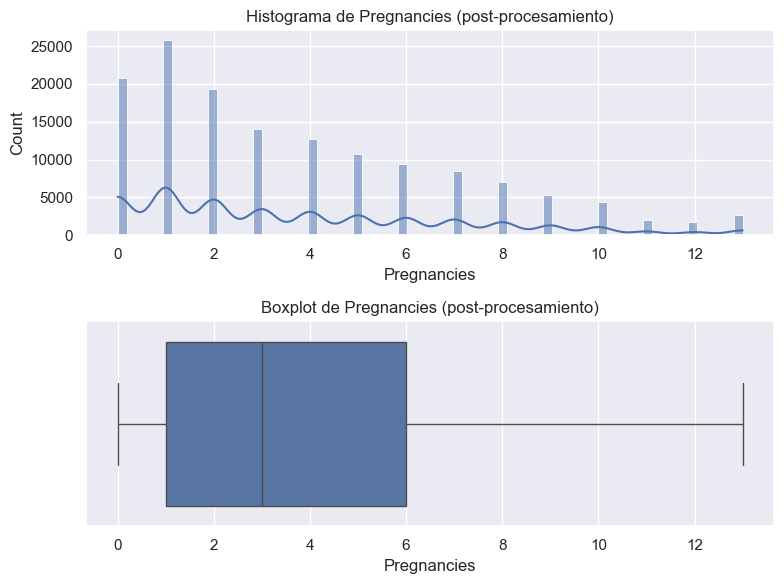

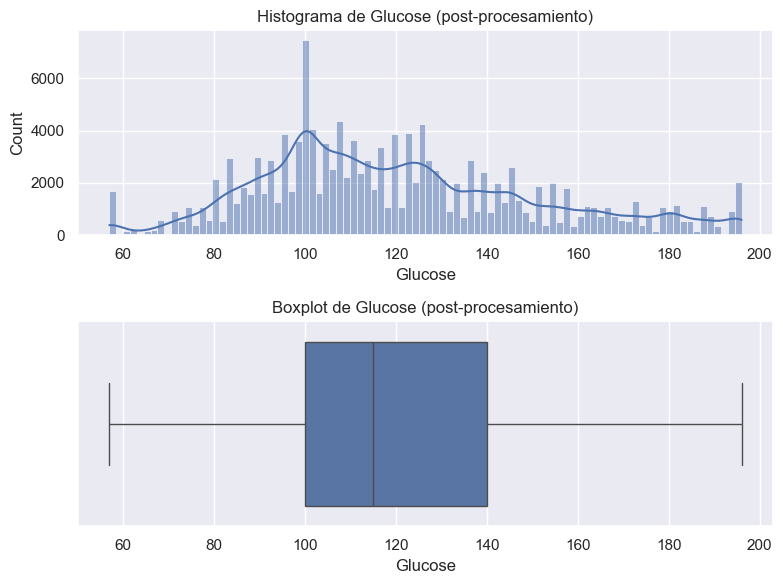

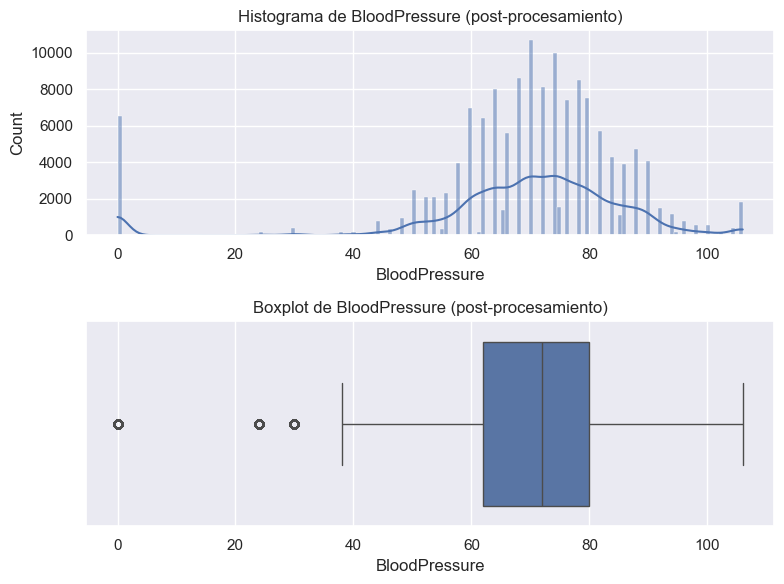

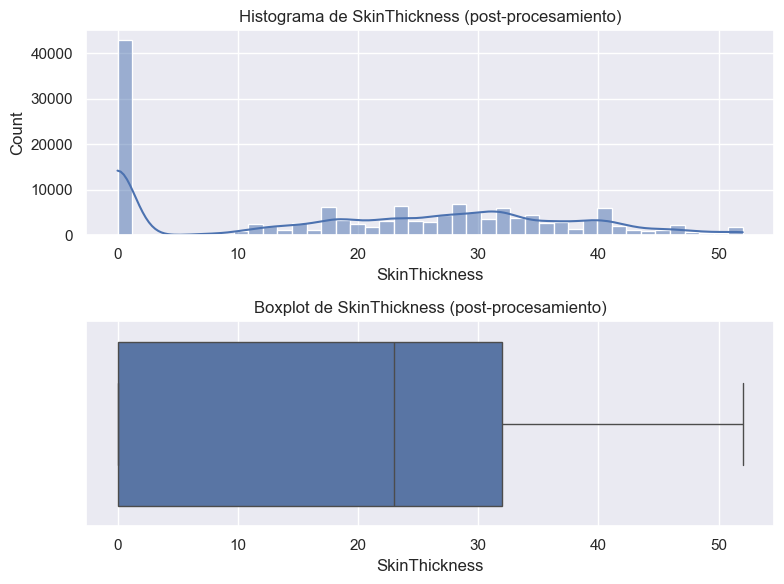

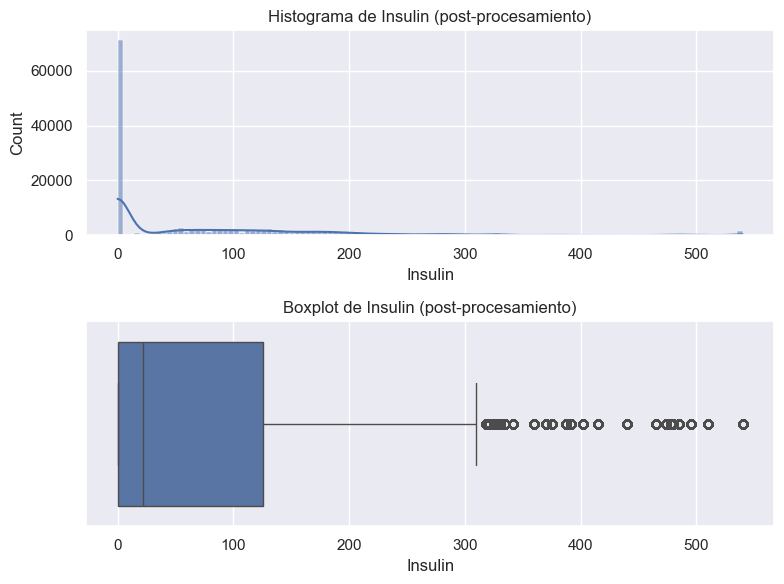

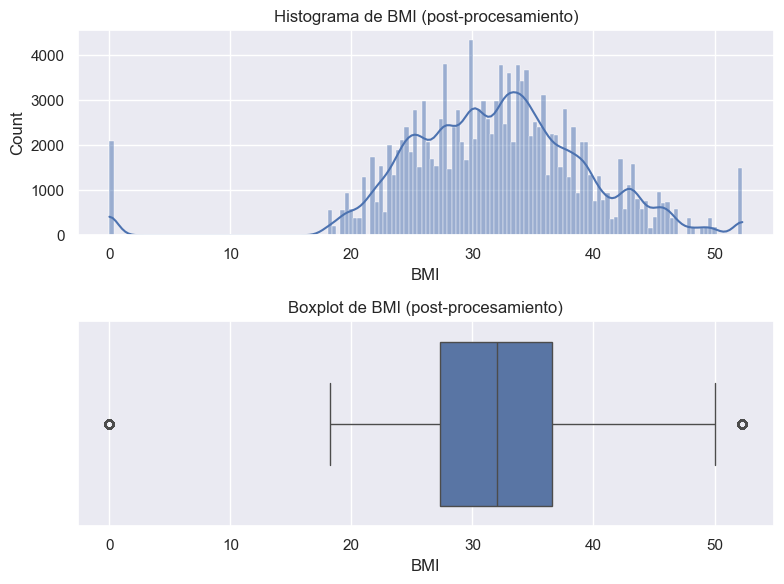

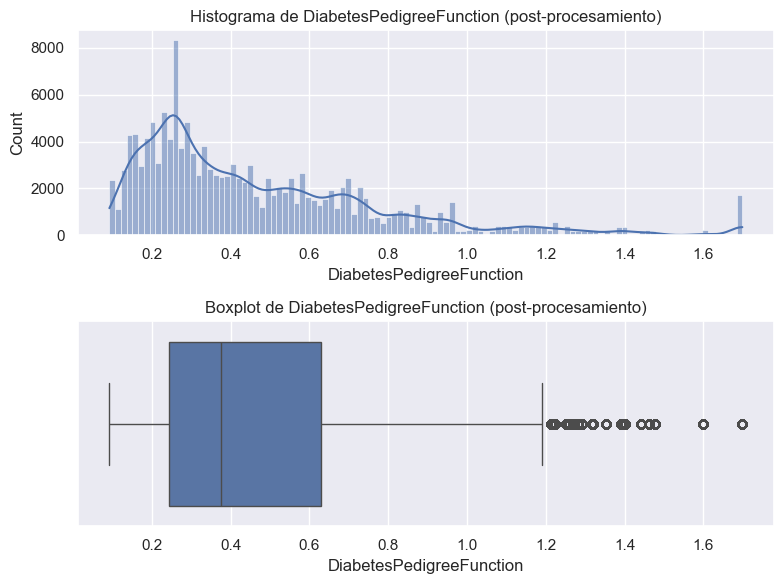

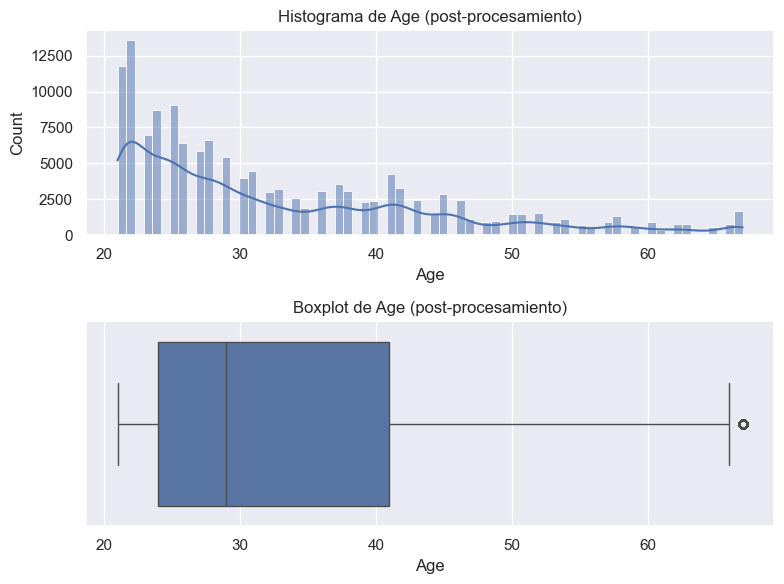

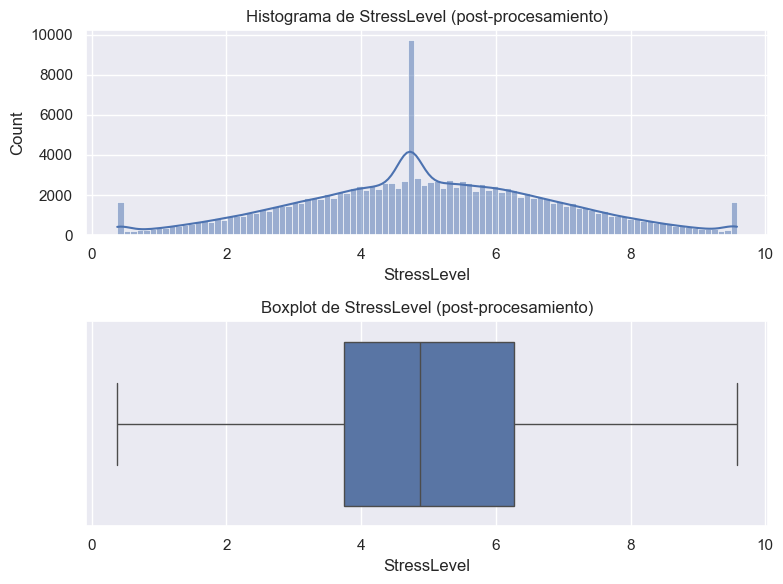

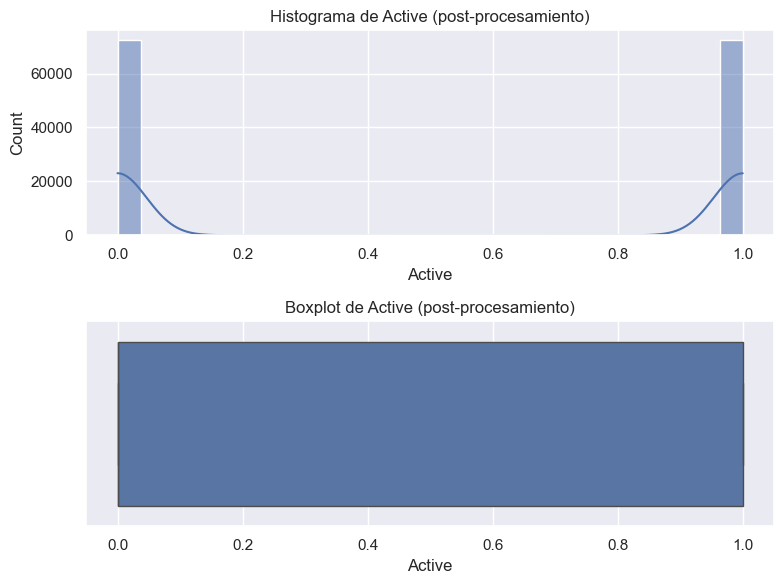

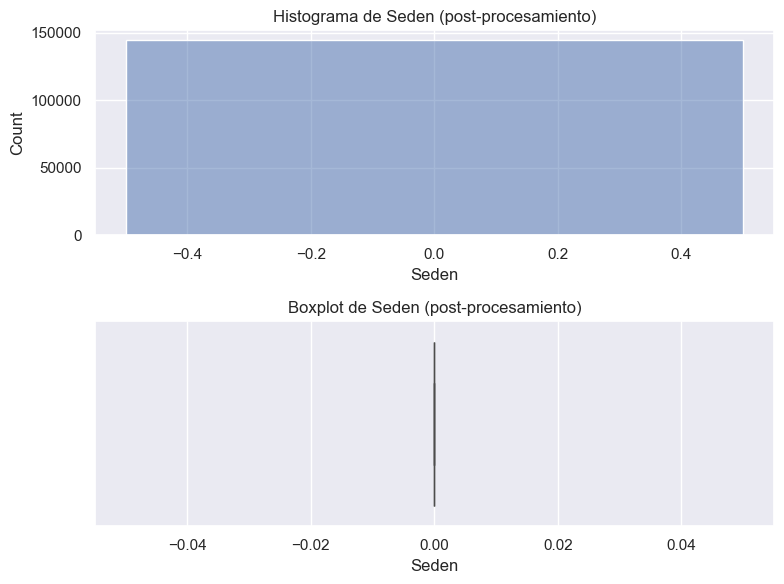

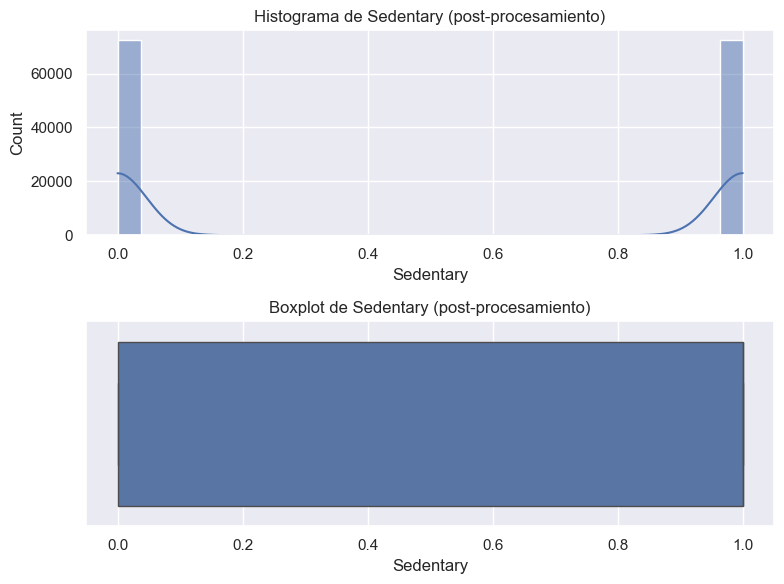

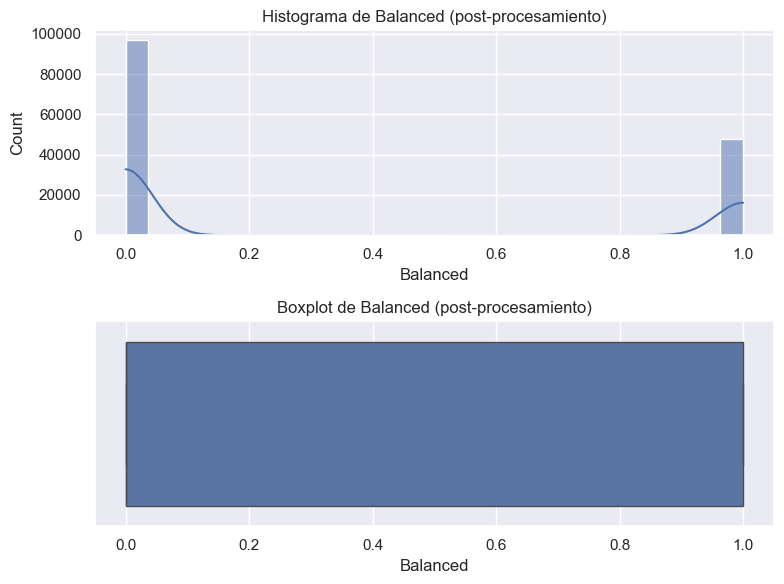

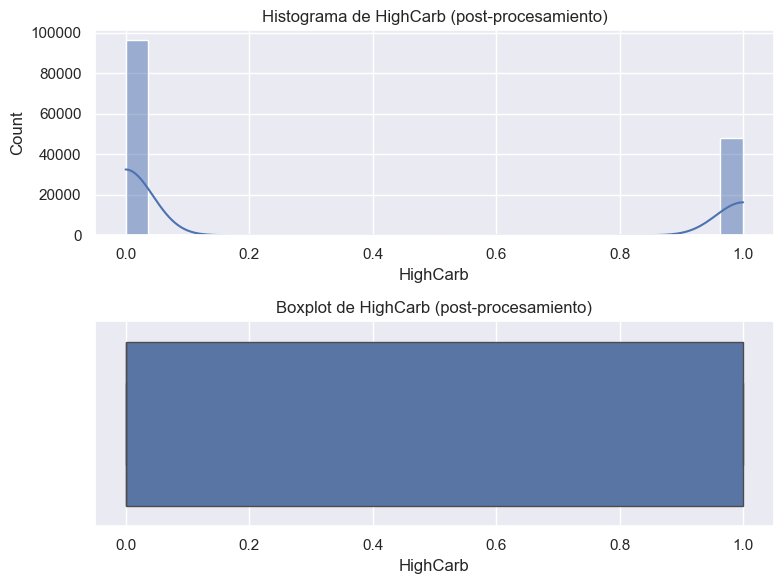

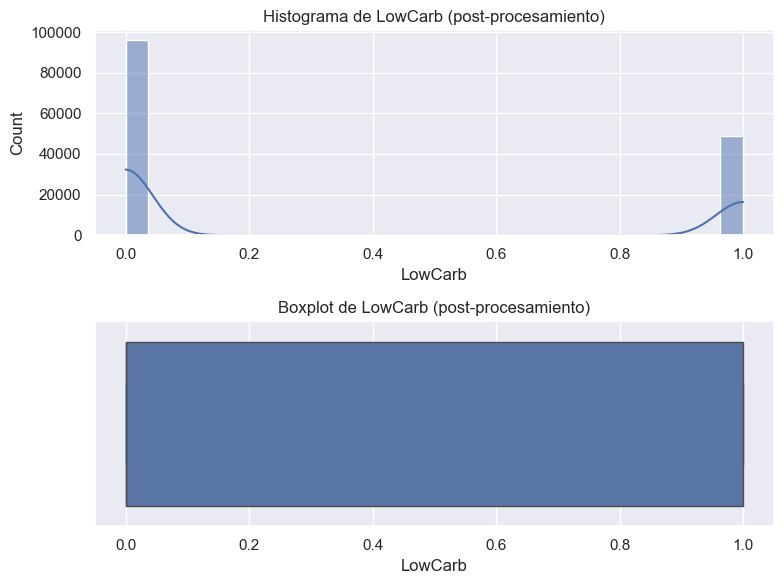

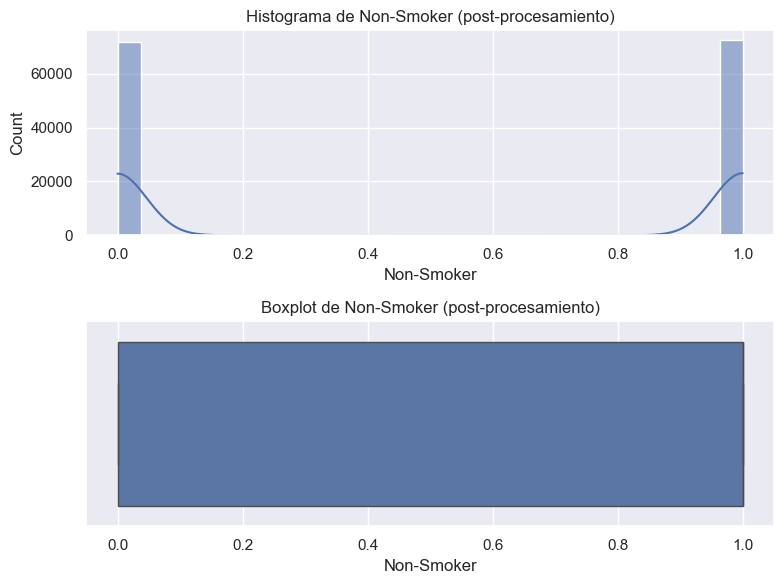

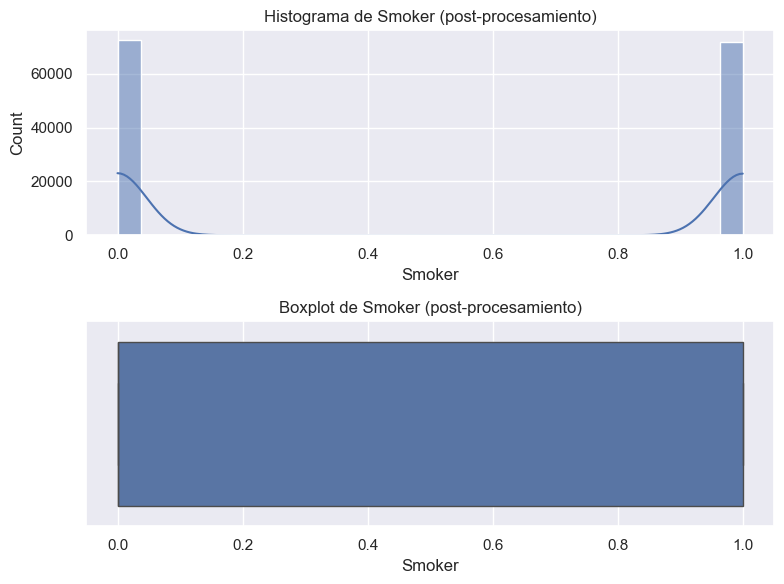

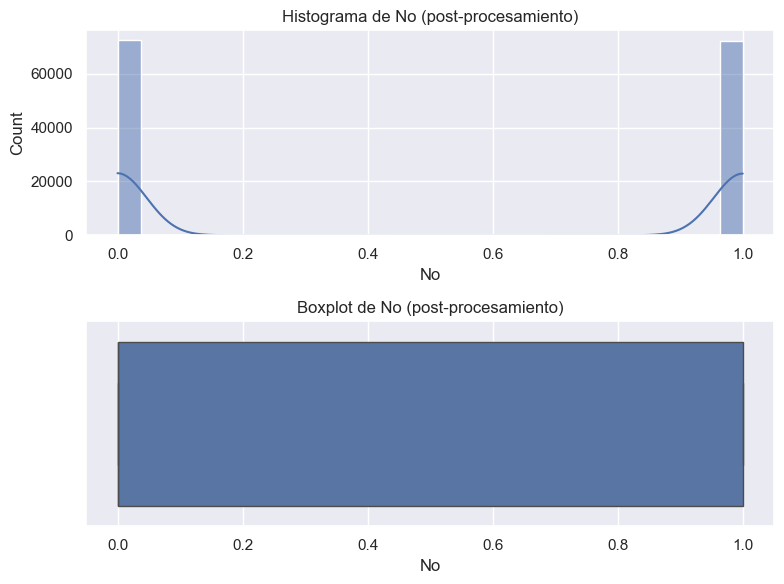

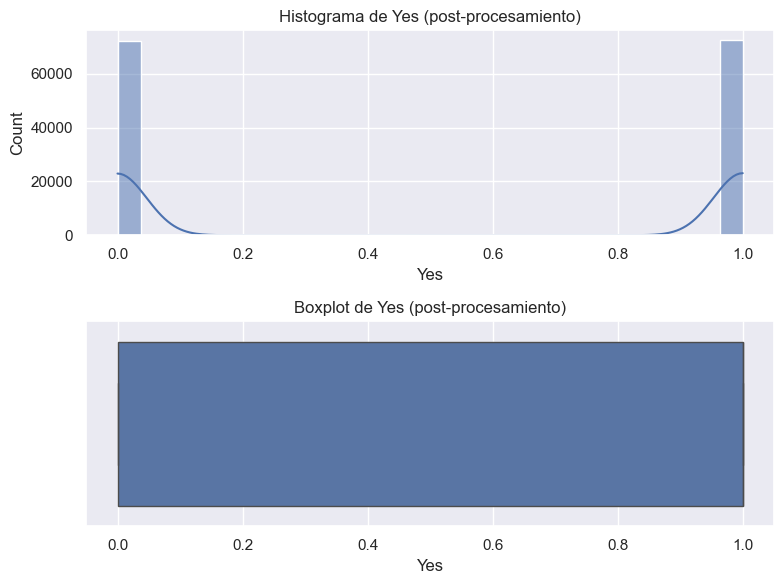

Preprocesamiento columna por columna finalizado. df -> df_proc -> df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Pregnancies               144641 non-null  float64
 1   Glucose                   144641 non-null  float64
 2   BloodPressure             144641 non-null  float64
 3   SkinThickness             144641 non-null  float64
 4   Insulin                   144641 non-null  float64
 5   BMI                       144641 non-null  float64
 6   DiabetesPedigreeFunction  144641 non-null  float64
 7   Age                       144641 non-null  float64
 8   Outcome                   144641 non-null  int64  
 9   StressLevel               144641 non-null  float64
 10  Active                    144641 non-null  float64
 11  Seden                     144641 non-null  float64
 12  Sedentary                 14464

In [10]:

# ==================== PREPROCESAMIENTO COLUMNA POR COLUMNA ====================
# Basado en el estilo del notebook: imputación con SimpleImputer(strategy='most_frequent'),
# conversión numérica con errors='coerce', winsorización de extremos (1% por cola),
# y visualización con histogramas y boxplots. No se crean features nuevas ni se eliminan filas.

from sklearn.impute import SimpleImputer
from scipy.stats import mstats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un dataframe procesado independiente desde el df con dummies
df_proc = df.copy()

# Separar target si existe en columnas
target_col = 'Outcome' if 'Outcome' in df_proc.columns else None
if target_col is not None:
    y = df_proc[target_col]
else:
    y = None

print("Resumen inicial (df_proc):")
print(df_proc.info())
print(df_proc.head())
print("-"*100)

# Intento de conversión a numérico para columnas object/categoría que sean numéricas en texto
for col in df_proc.columns:
    if col == target_col:
        continue
    if df_proc[col].dtype == 'object':
        # Conversión tentativa a numérico
        before_na = df_proc[col].isna().sum()
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')
        after_na = df_proc[col].isna().sum()
        print(f"[{col}] object -> numeric (coerce). NaN antes: {before_na}, después: {after_na}")

print("-"*100)
print("Tipos luego de convertir a numérico donde aplica:")
print(df_proc.dtypes)

# Imputación por moda para TODAS las columnas (como en el notebook), respetando estilo
# (el cuaderno usa 'most_frequent' para columnas problemáticas como 'ca' y 'thal'. Aquí generalizamos.)
imputer_mode = SimpleImputer(strategy='most_frequent')
cols_to_impute = [c for c in df_proc.columns if c != target_col]
df_proc[cols_to_impute] = imputer_mode.fit_transform(df_proc[cols_to_impute])

print("-"*100)
print("Después de imputación por moda:")
print(df_proc.isna().sum())

# Winsorización (1% por cola) para columnas numéricas (excepto la etiqueta)
num_cols = [c for c in df_proc.select_dtypes(include=[np.number]).columns if c != target_col]

for col in num_cols:
    # Registrar cuantiles antes
    q1, q99 = df_proc[col].quantile(0.01), df_proc[col].quantile(0.99)
    df_proc[col] = mstats.winsorize(df_proc[col], limits=[0.01, 0.01])
    print(f"[{col}] winsorize 1%-99% | q01={q1:.4f}, q99={q99:.4f}")

print("-"*100)
print("Descripción estadística post-winsorización:")
print(df_proc[num_cols].describe())

# Visualizaciones por columna numérica (histograma + boxplot)
for col in num_cols:
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    sns.histplot(df_proc[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histograma de {col} (post-procesamiento)")
    sns.boxplot(x=df_proc[col], ax=ax[1])
    ax[1].set_title(f"Boxplot de {col} (post-procesamiento)")
    plt.tight_layout()
    plt.show()

# Reasignar df si quieres que el resto del notebook use el DataFrame procesado
df = df_proc.copy()

print("Preprocesamiento columna por columna finalizado. df -> df_proc -> df")
print(df.info())


# Modelos implementados

## 1. Perceptron

In [11]:
# === Base de datos y variable objetivo ===
import pandas as pd
import numpy as np

# Elegir df_base: df_clean si existe; si no, df
if 'df_clean' in globals():
    df_base = df_clean.copy()
elif 'df' in globals():
    df_base = df.copy()
else:
    raise NameError("No encuentro 'df' ni 'df_clean'. Carga primero tu DataFrame.")

# Elegir y_col automáticamente (prioriza 'Outcome')
candidatas = [c for c in df_base.columns 
              if c.lower() in ["outcome","target","class","label","y","objetivo"]]
y_col = "Outcome" if "Outcome" in df_base.columns else (candidatas[0] if candidatas else None)

if y_col is None:
    raise ValueError("No pude detectar la columna objetivo. Define manualmente y_col = 'TU_COLUMNA'.")

print("Usando y_col:", y_col)

# Separar X e y
X = df_base.drop(columns=[y_col])
y = df_base[y_col]

# Si y es booleana/strings, convertir a 0/1 cuando sea posible
if y.dtype == 'O' or str(y.dtype).startswith('category') or y.dtype == bool:
    y_lower = y.astype(str).str.lower()
    mapas = [
        ({"yes":1,"no":0}, {"si":1,"no":0}),
        ({"true":1,"false":0},),
        ({"positivo":1,"negativo":0},),
        ({"1":1,"0":0},),
    ]
    mapped = None
    for grupo in mapas:
        for m in grupo:
            if set(y_lower.unique()) >= set(m.keys()):
                mapped = y_lower.map(m)
                break
        if mapped is not None:
            break
    if mapped is not None:
        y = mapped.astype(int)
        print("Se mapeó y a {0,1}.")
    else:
        print("Aviso: y es categórica con valores:", y.unique())


Usando y_col: Outcome


In [12]:
# === Reconstrucción de columnas + limpieza de y ===
import numpy as np
import pandas as pd

# Columnas por tipo (sobre X actual)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

# Quitar filas donde la y esté NaN (modelo no puede entrenar con y faltante)
mask_y_ok = ~pd.isna(y)
dropped_y = (~mask_y_ok).sum()
if dropped_y > 0:
    print(f"Se eliminaron {dropped_y} filas por y NaN.")
X = X.loc[mask_y_ok].reset_index(drop=True)
y = y.loc[mask_y_ok].reset_index(drop=True)


Numéricas: 19 | Categóricas: 0


In [13]:
# === Split + Preprocesamiento con IMPUTACIÓN ===
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Split 70/30 (estratificado si es binario/multiclase)
stratify_arg = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=stratify_arg
)

# Pipelines de preprocesamiento por tipo
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Compatibilidad con versiones de sklearn (sparse_output vs sparse)
try:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", cat_enc),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)


In [14]:
# === Perceptrón en Pipeline (con imputación integrada) ===
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

perc = Perceptron(
    penalty=None,
    alpha=0.0001,
    fit_intercept=True,
    max_iter=1000,
    tol=1e-3,
    shuffle=True,
    eta0=0.1,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    random_state=42
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", perc),
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.6214

Matriz de confusión:
 [[24391 10309]
 [ 6121  2572]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75     34700
           1       0.20      0.30      0.24      8693

    accuracy                           0.62     43393
   macro avg       0.50      0.50      0.49     43393
weighted avg       0.68      0.62      0.65     43393



In [15]:
# === RESUMEN DEL CONJUNTO DE PRUEBA Y OBJETIVO ===
import pandas as pd
import numpy as np
from collections import Counter

print(f"🔎 Variable objetivo analizada (y_col): {y_col}")

print(f"Tamaño train: {len(y_train):,} | test: {len(y_test):,} | total: {len(y_train)+len(y_test):,}")

def distr(y, nombre):
    c = Counter(y)
    tot = len(y)
    filas = [{"clase": k, "conteo": v, "porc": f"{v/tot: .2%}"} for k, v in sorted(c.items(), key=lambda kv: kv[0])]
    df_ = pd.DataFrame(filas)
    print(f"\nDistribución de clases en {nombre}:")
    display(df_)

distr(y_train, "TRAIN")
distr(y_test, "TEST")

# Columnas originales usadas
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print(f"Features numéricas ({len(num_cols)}): {num_cols[:10]}{' ...' if len(num_cols)>10 else ''}")
print(f"Features categóricas ({len(cat_cols)}): {cat_cols[:10]}{' ...' if len(cat_cols)>10 else ''}")


🔎 Variable objetivo analizada (y_col): Outcome
Tamaño train: 101,248 | test: 43,393 | total: 144,641

Distribución de clases en TRAIN:


,clase,conteo,porc
0,0,80966,79.97%
1,1,20282,20.03%



Distribución de clases en TEST:


,clase,conteo,porc
0,0,34700,79.97%
1,1,8693,20.03%


Features numéricas (19): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'StressLevel', 'Active'] ...
Features categóricas (0): []


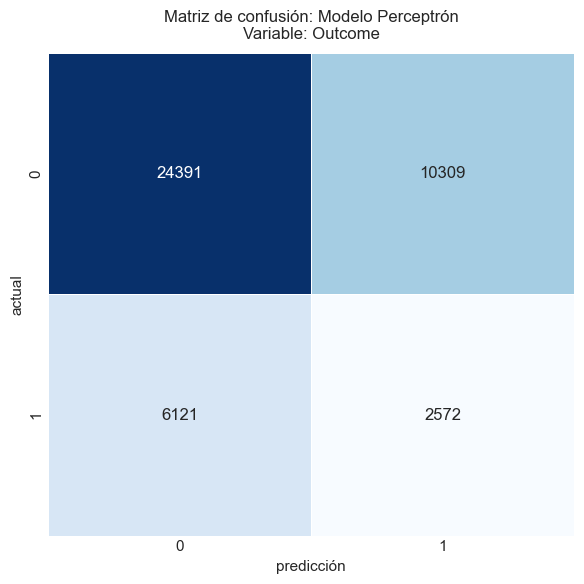

In [16]:
# === MATRIZ DE CONFUSIÓN ESTILO "CUADRÍCULA LIMPIA" ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Si quieres renombrar clases (ejemplo para binario):
# label_map = {0: "negativo", 1: "positivo"}
# y_test_plot = pd.Series(y_test).map(label_map).fillna(y_test).values
# y_pred_plot = pd.Series(y_pred).map(label_map).fillna(y_pred).values

y_test_plot = y_test
y_pred_plot = y_pred
clases = np.unique(y_test_plot)

cm = confusion_matrix(y_test_plot, y_pred_plot, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')

ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Modelo Perceptrón\nVariable: {y_col}", fontsize=12, pad=10)

# cuadrícula suave
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


1) Qué muestra
La figura presenta la matriz de confusión correspondiente al modelo Perceptrón aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones y una distribución de clases desbalanceada de por ahi de 79.97% clase 0 y 20.03% clase 1.
2) Hallazgo principal 
El modelo clasificó correctamente 24,391 casos negativos y 2572 casos positivos, mientras que 10,309 casos negativos fueron clasificados erróneamente como positivos y 6121 positivos como negativos. Esto refleja una mayor capacidad para identificar la clase 0 y una baja recuperación de la clase 1. Esto se ve reflehado en que el  recall del clase positivo es de  aproximadamente 30.0%, meintras el recall de la clase 0 tiene un recall de 70% que tambien se ve reflehado en que clasifico correctamente 24,391 cassos.

3) Interpretación
El Perceptrón tiende a predecir la clase mayoritaria la que es la clase 0, esto sugiere que la frontera de decisión lineal no logra separar adecuadamente ambas clases. La colinealidad entre variables y la falta de separabilidad lineal explican la alta tasa de falsos negativos y falsos positivos.

4) Implicación
El bajo recall y precisión para la clase 1 implican que el modelo falla en detectar casos positivos, lo cual sería problemático en contextos donde la clase minoritaria es crítica. Se recomienda ajustar el umbral de decisión o aplicar técnicas de balanceo como SMOTE o undersampling antes del entrenamiento.

5) Limitaciones
Riesgo de subajuste ya que el modelo lineal no capta relaciones complejas entre las 19 variables numéricas. Además, el fuerte desbalance de clases limita la capacidad predictiva sobre la clase 1.

Métrica,Valor
Accuracy,0.6214
Error (1-Acc),0.3786
TPR / Recall,0.2959
FPR,0.2971
Especificidad (TNR),0.7029
Precision (PPV),0.1997
NPV,0.7994
F1-score,0.2384
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.4994



Componentes (pos_label = 1):


,Pred 0,Pred 1
Real 0,24391,10309
Real 1,6121,2572


,precision,recall,f1-score,support
0,0.7994,0.7029,0.7481,34700.0000
1,0.1997,0.2959,0.2384,8693.0000
accuracy,0.6214,0.6214,0.6214,0.6214
macro avg,0.4995,0.4994,0.4932,43393.0000
weighted avg,0.6792,0.6214,0.6460,43393.0000


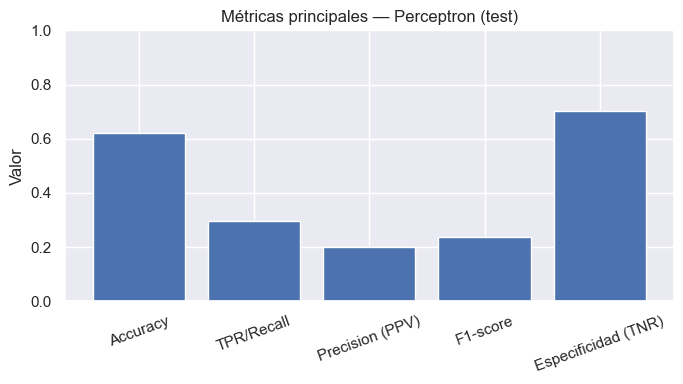

In [17]:
# === MÉTRICAS COMPLETAS Y LIMPIAS ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, matthews_corrcoef
)

# ----- Config: etiqueta positiva para binario -----
classes = np.unique(y_test)
# Si existe la clase 1 la tomamos como positiva; si no, la mayor
pos_label = 1 if 1 in classes else classes.max()

# ----- Confusion matrix -----
cm = confusion_matrix(y_test, y_pred, labels=classes)

def metrics_binary(y_true, y_hat, pos_label):
    # Re-etiquetar a binario (pos_label vs resto) si hay más de 2 clases
    if len(np.unique(y_true)) > 2:
        y_true_bin = (pd.Series(y_true).values == pos_label).astype(int)
        y_hat_bin  = (pd.Series(y_hat ).values == pos_label).astype(int)
    else:
        y_true_bin = pd.Series(y_true).values
        y_hat_bin  = pd.Series(y_hat ).values

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_hat_bin, labels=[0,1]).ravel()
    total = tn + fp + fn + tp

    acc   = accuracy_score(y_true_bin, y_hat_bin)
    error = 1 - acc
    tpr   = tp / (tp + fn) if (tp + fn) > 0 else 0.0       # Recall / Sensibilidad
    fpr   = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tnr   = tn / (tn + fp) if (tn + fp) > 0 else 0.0       # Especificidad
    ppv   = precision_score(y_true_bin, y_hat_bin, zero_division=0)  # Precision
    npv   = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1    = f1_score(y_true_bin, y_hat_bin, zero_division=0)
    prev  = (tp + fn) / total if total > 0 else 0.0        # Prevalencia positiva
    bacc  = (tpr + tnr) / 2
    mcc   = matthews_corrcoef(y_true_bin, y_hat_bin) if total > 0 else 0.0

    # AUC si hay score disponible
    auc = None
    try:
        if 'pipe' in globals():
            # Preferimos decision_function; si no, probas
            if hasattr(pipe, "decision_function"):
                s = pipe.decision_function(X_test)
                score = s if s.ndim == 1 else s[:, list(classes).index(pos_label)]
            elif hasattr(pipe, "predict_proba"):
                proba = pipe.predict_proba(X_test)
                score = proba[:, list(classes).index(pos_label)] if proba.ndim == 2 else proba
            else:
                score = None
            if score is not None:
                auc = roc_auc_score(y_true_bin, score)
    except Exception:
        pass

    return {
        "TN": tn, "FP": fp, "FN": fn, "TP": tp, "Total": total,
        "Accuracy": acc, "Error": error, "TPR/Recall": tpr, "FPR": fpr,
        "Especificidad (TNR)": tnr, "Precision (PPV)": ppv, "NPV": npv,
        "F1-score": f1, "Prevalencia (P(Y=1))": prev, "Balanced Acc.": bacc,
        "MCC": mcc, "AUC": auc
    }

bin_metrics = metrics_binary(y_test, y_pred, pos_label)

# ----- Tabla “resumen ejecutivo” -----
filas = [
    ("Accuracy",                 bin_metrics["Accuracy"]),
    ("Error (1-Acc)",            bin_metrics["Error"]),
    ("TPR / Recall",             bin_metrics["TPR/Recall"]),
    ("FPR",                      bin_metrics["FPR"]),
    ("Especificidad (TNR)",      bin_metrics["Especificidad (TNR)"]),
    ("Precision (PPV)",          bin_metrics["Precision (PPV)"]),
    ("NPV",                      bin_metrics["NPV"]),
    ("F1-score",                 bin_metrics["F1-score"]),
    ("Prevalencia P(Y=1)",       bin_metrics["Prevalencia (P(Y=1))"]),
    ("Balanced Accuracy",        bin_metrics["Balanced Acc."]),
    ("MCC",                      bin_metrics["MCC"]),
    ("AUC (si aplica)",          bin_metrics["AUC"]),
]
resumen_df = pd.DataFrame(filas, columns=["Métrica", "Valor"])
display(resumen_df.style.format({"Valor": "{:.4f}"}).hide(axis="index"))

# ----- Componentes de la matriz de confusión -----
cm_df = pd.DataFrame(
    [[bin_metrics["TN"], bin_metrics["FP"]],
     [bin_metrics["FN"], bin_metrics["TP"]]],
    index=["Real 0", "Real 1"],
    columns=["Pred 0", "Pred 1"]
)
print(f"\nComponentes (pos_label = {pos_label}):")
display(cm_df)

# ----- Tabla por clase (macro/weighted incluidas) -----
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
por_clase = pd.DataFrame(report).T
display(por_clase.style.format("{:.4f}"))

# ====== (Opcional) Gráfico rápido de barras con las métricas principales ======
try:
    import matplotlib.pyplot as plt

    claves = ["Accuracy","TPR/Recall","Precision (PPV)","F1-score","Especificidad (TNR)"]
    vals   = [bin_metrics[k] for k in claves]

    plt.figure(figsize=(7,4))
    plt.bar(claves, vals)
    plt.ylim(0, 1)
    plt.title(f"Métricas principales — {getattr(pipe.named_steps['clf'], '__class__', type('x',(),{}) ).__name__} (test)")
    plt.ylabel("Valor")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
except Exception:
    pass


1) Qué muestra:
Resumen de métricas de desempeño Accuracy, Recall, Precision, F1-score, Especificidad del modelo Perceptrón sobre el conjunto de prueba.
2) Hallazgo principal:
El modelo alcanza una accuracy de 0.62, pero su recall=0.30 y F1-score= 0.23 son bajos, lo que refleja un desequilibrio entre las clases. La especificidad = 0.70 es significativamente mayor, mostrando que el modelo identifica bien los casos negativos
3) Interpretación:
El buen desempeño en especificidad frente a un bajo recall confirma que el modelo está sesgado hacia la clase mayoritaria. El bajo F1 indica poca armonía entre precisión y sensibilidad. Esto puede deberse a que las características no generan fronteras separables linealmente o a que el umbral = 0.5 no es adecuado.
4) Implicación:
El modelo no es útil si el objetivo es detectar correctamente la clase 1. Se requiere explorar ajustes de regularización y de normalización.
5) Limitaciones:
Posible insuficiencia de capacidad del Perceptrón simple para modelar la complejidad de los datos. Además, el desbalance de clases amplifica la aparente buena precisión en la clase mayoritaria, generando una visión optimista del accuracy.

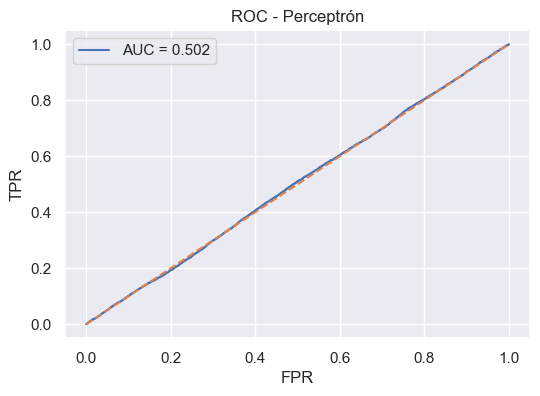

In [18]:
# === Curva ROC / AUC (solo binario) ===
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

clases = np.unique(y_test)
if len(clases) == 2:
    y_score = pipe.decision_function(X_test)
    fpr, tpr, thr = roc_curve(y_test, y_score, pos_label=clases.max())
    auc = roc_auc_score(y_test, y_score)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC - Perceptrón")
    plt.legend()
    plt.show()
else:
    print("ROC/AUC omitido: y no es binaria.")


1) Qué muestra:
Curva ROC del modelo Perceptrón sobre el conjunto de prueba, con un área bajo la curva AUC = 0.502.
2) Hallazgo principal:
Con el valor del AUC = 0.502 = 50% esto nos indica un desempeño equivalente al azar. No existe una capacidad real de discriminación entre clases.
3) Interpretación:
El modelo no logra generar una separación efectiva entre clases 0 y 1. Esto confirma que el Perceptrón, al ser lineal, no captura patrones útiles en los datos o está dominado por la clase mayoritaria durante el entrenamiento.
4) Implicación:
No se recomienda utilizar este modelo como clasificador final. Será necesario aplicar técnicas de balanceo o modelos no lineales como árboles y MLP para mejorar la discriminación.
5) Limitaciones:
El AUC puede ser poco informativo en escenarios con fuerte desbalance de clases. Además, el bajo desempeño podría reflejar una mala calibración de probabilidades, propia de modelos lineales sin ajustes adicionales

## 2. Adaline

In [19]:
# === Selección de df_base e y_col (solo si no lo tienes arriba) ===
import pandas as pd, numpy as np

if 'df_clean' in globals():
    df_base = df_clean.copy()
elif 'df' in globals():
    df_base = df.copy()
else:
    raise NameError("No encuentro df ni df_clean.")

# Detectar y_col (prioriza Outcome)
candidatas = [c for c in df_base.columns if c.lower() in ["outcome","target","class","label","y","objetivo"]]
y_col = "Outcome" if "Outcome" in df_base.columns else (candidatas[0] if candidatas else None)
assert y_col is not None, "Define y_col manualmente."

X = df_base.drop(columns=[y_col])
y = df_base[y_col]

# Limpiar y NaN
ok = ~pd.isna(y); X, y = X.loc[ok], y.loc[ok]

# Tipos
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Split + Preprocess con imputación
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y if y.nunique()>1 else None
)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
try:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", cat_enc)])

preprocess = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    remainder="drop"
)


In [20]:
# === ADALINE (pérdida cuadrática) en Pipeline ===
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

adaline = SGDClassifier(
    loss="squared_error",
    penalty=None,
    learning_rate="constant",
    eta0=0.01,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

pipe_adaline = Pipeline([
    ("prep", preprocess),
    ("clf", adaline),
])

pipe_adaline.fit(X_train, y_train)
y_pred_adaline = pipe_adaline.predict(X_test)


# === EXTRA: calcular 'losses' (SSE por época) sin modificar tu pipeline ===
import numpy as np

# Usar el mismo preprocesamiento ya ajustado dentro del pipeline
prep = pipe_adaline.named_steps["prep"]
prep = Pipeline(steps=pipe.steps[:-1])  # si tu pipeline se llama diferente, ajústalo
Xtr = prep.transform(X_train)

# Clasificador auxiliar SOLO para obtener la curva (no altera tu modelo entrenado)
adaline_curve = SGDClassifier(
    loss="squared_error",
    penalty=None,
    learning_rate="constant",
    eta0=0.01,
    max_iter=1,      # 1 iter por época
    tol=None,
    random_state=42,
    warm_start=True
)

# Objetivos en {-1, +1} únicamente para calcular SSE como en ADALINE
y_tr = np.asarray(y_train)
u = np.unique(y_tr)
y_tr_bin = np.where(y_tr == u.max(), 1.0, -1.0) if set(u) == {0, 1} else \
           np.where(y_tr == u[-1], 1.0, -1.0)

losses = []
classes_pf = np.unique(y_train)
n_epochs = 100

for _ in range(n_epochs):
    adaline_curve.partial_fit(Xtr, y_train, classes=classes_pf)
    y_score = adaline_curve.decision_function(Xtr).astype(float)  # salida lineal
    losses.append(float(np.sum((y_tr_bin - y_score) ** 2)))
# === FIN EXTRA ===



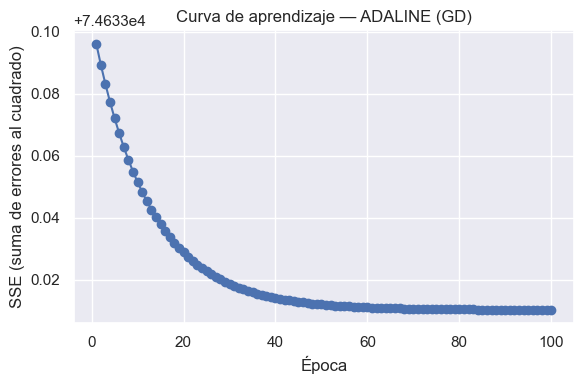

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker="o")
plt.xlabel("Época")
plt.ylabel("SSE (suma de errores al cuadrado)")
plt.title("Curva de aprendizaje — ADALINE (GD)")
plt.tight_layout(); plt.show()


1) Qué muestra
La gráfica representa la evolución del error cuadrático el SSE( suma de errores al cuadrado) durante el entrenamiento del modelo adaline con descenso de gradiente, a lo largo de 100 épocas.
2) Hallazgo principal 
El error disminuye de manera continua y estable, desde un valor inicial alto  apoximado 0.10 hasta estabilizarse cerca de 0.02 después de unas 40–50 épocas, lo cual indica que el modelo converge correctamente.
3) Interpretación
Esta tendencia decreciente refleja que el descenso de gradiente logra minimizar el error de predicción a lo largo del entrenamiento. El comportamiento suave y monótono indica que no hay inestabilidad numérica ni sobreajuste temprano, y que los pesos se están ajustando gradualmente hacia un mínimo estable.Dado que Adaline utiliza una función de activación lineal y una función de costo MSE, este patrón es típico de un modelo lineal bien configurado en datos escalados.
4) Implicación 
El modelo aprendió una frontera lineal estable, pero la convergencia del error no garantiza buena capacidad de clasificación, ya que el error SSE evalúa diferencias numéricas, no aciertos de clase. Esto implica que el Adaline puede haber aprendido correctamente su mejor frontera lineal, pero si las clases no son linealmente separables, su rendimiento seguirá siendo limitado.
5) Limitaciones
unos limitaciones que estan presentes son la linealidad por lo que aunque el error converge, el modelo no puede capturar relaciones no lineales entre las variables.Ademas, sensibilidad al escalado por que sin normalización adecuada, la convergencia habría sido errática o incluso divergente.

In [22]:
# === Evaluación ADALINE ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (ADALINE):", round(accuracy_score(y_test, y_pred_adaline), 4))
print("\nReporte de clasificación (ADALINE):\n",
      classification_report(y_test, y_pred_adaline, zero_division=0))

# Matriz de confusión explicativa (como la versión “limpia”)
cm = confusion_matrix(y_test, y_pred_adaline)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# Curva ROC / AUC si el problema es binario
clases = np.unique(y_test)
if len(clases)==2:
    # Para ADALINE, hay scores lineales:
    scores = pipe_adaline.decision_function(X_test)
    auc = roc_auc_score(y_test, scores)
    print(f"AUC (ADALINE): {auc:.4f}")


Accuracy (ADALINE): 0.7887

Reporte de clasificación (ADALINE):
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     34700
           1       0.20      0.02      0.03      8693

    accuracy                           0.79     43393
   macro avg       0.50      0.50      0.46     43393
weighted avg       0.68      0.79      0.71     43393



,Pred 0,Pred 1
Real 0,34061,639
Real 1,8531,162


AUC (ADALINE): 0.4968


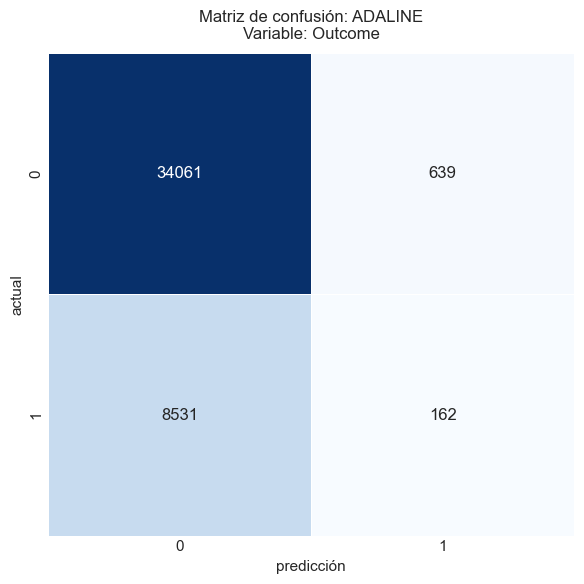

In [23]:
# === Matriz de confusión visual (estilo ejemplo) ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_adaline, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: ADALINE\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


1) Qué muestra:
La figura presenta la matriz de confusión correspondiente al modelo Perceptrón aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones
2) Hallazgo principal:
Por lo que podemos ver, el modelo a primera vista parece ser preciso, ya que presume de una precisión de 0.7887, pero esto parece ser engañoso, ya que si bien el modelo obtuvo con precisión 34.061 resultados negativos verdaderos, y esto se respalda aún más con su recall = 0.98 y la f1 score = 0,88, que son altos. Sin embargo, una vez que observamos el lado positivo, vemos que la precisión dada no se refleja realmente con precisión, ya que el modelo solo pudo obtener 162 positivos verdaderos, lo cual es muy bajo y eso se muestra aún más con el recall de la clase 1 = 0.02 y el f1 score  = 0.03, lo que básicamente significa que el modelo no pudo predecir la clase 1 y solo la clase 0, lo cual se respalda con el modelo dado tantos falsos negativos (8531) en comparación con los falsos positivos que fueron solo 639.
3) Interpretación:
Este comportamiento se debe a que adaline es un modelo lineal que minimiza el error cuadrático, lo que favorece la clase mayoritaria para reducir el error de secuencia general (SSE). Es probable que el límite de clase no sea lineal, por lo que un separador lineal no puede capturar la región minoritaria. Además, el umbral de decisión fijo (0,5), combinado con el desequilibrio de clase, obliga al modelo a clasificar casi todas las muestras como clase 0.
4) Implicación:
Como adaline esta ahora presenta un alto riesgo de falsos negativos y no es adecuada para tareas de detección de clases minoritarias, por lo que lo que se debe hacer es ajustar el umbral de decisión, aplicar ponderación de clase o volver a muestrear todo esto para recuperar el rendimiento de la clase 1.
5) Limitaciones:
Si bien el modelo no muestra un sobreajuste visible, sí vemos un fuerte sesgo hacia la clase dominante.

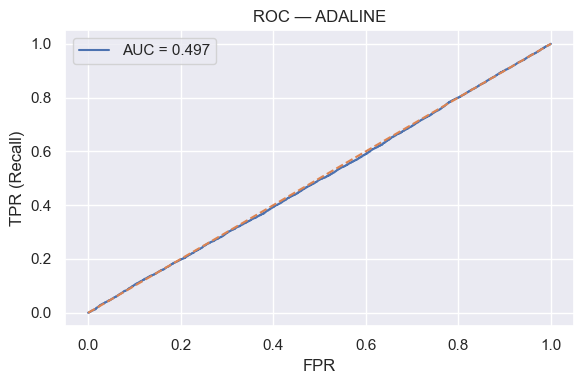

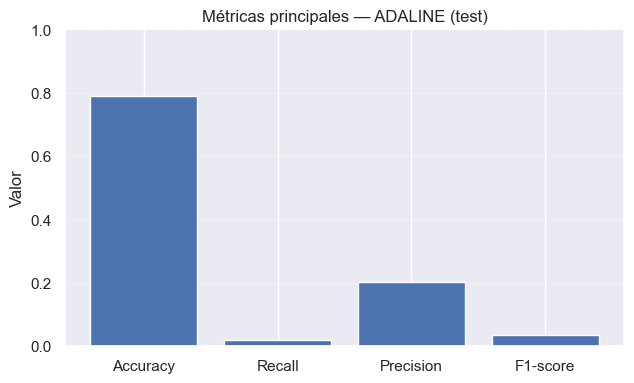

In [24]:
# === ROC/AUC (binario) + barras de métricas clave ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

if len(np.unique(y_test))==2:
    scores = pipe_adaline.decision_function(X_test)
    fpr, tpr, thr = roc_curve(y_test, scores, pos_label=max(np.unique(y_test)))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — ADALINE")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) sobre ADALINE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_adaline),
    "Recall":    recall_score(y_test, y_pred_adaline, average="binary" if len(np.unique(y_test))==2 else "weighted", zero_division=0),
    "Precision": precision_score(y_test, y_pred_adaline, average="binary" if len(np.unique(y_test))==2 else "weighted", zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_adaline, average="binary" if len(np.unique(y_test))==2 else "weighted", zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — ADALINE (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Roc -- Adaline
1) Qué muestra:
La graphica es la del curva ded Roc que en este caso esta evalúando el modelo adaline en la variable de resultado utilizando datos de prueba. Tiene un AUC = 0,497.
2) Hallazgo principal:
Con un valor de AUC cercano a 0,5 esto nos indica que el modelo no funciona mejor que una suposición aleatoria. Esto confirma que adaline no distingue eficazmente entre clases positivas y negativas.
3) Interpretación:
Dado que Adaline utiliza una activación lineal y una pérdida de error cuadrático, no puede capturar límites de decisión no lineales. El conjunto de datos desequilibrado y el umbral fijo (0,5) refuerzan su sesgo hacia la predicción de la clase 0, manteniendo la curva ROC cerca de la diagonal.
4) Implicación:
Este resultado sugiere la necesidad de equilibrar los datos, ajustar el umbral o usar un clasificador no lineal. Sin estos cambios, el modelo sigue siendo inadecuado para identificar casos de clases minoritarias.
5) Limitaciones:
El AUC del modelo confirma la ausencia de capacidad discriminatoria, aunque no parece estar sobreajustado. La limitación radica en el sesgo del modelo y los supuestos de separabilidad lineal.

Metricas Principales -- Adaline Test
1) Qué muestra:
El gráfico de barras resume las métricas de rendimiento de las pruebas de Adeline con Accuracy = 0,7887, Recall = 0,0186, Precisión =0,2022 y F1-score = 0,0341. Estas reflejan el comportamiento general de clasificación del modelo.
2) Hallazgo principal:
Aunque el accuracy parece alta = 0,7887 = 79%, esto es engañoso siendo que el recall y la F1-score son extremadamente bajas, lo que demuestra que el modelo casi nunca detecta casos de clase 1. Este desequilibrio hace que la alta precisión del modelo refleje principalmente predicciones correctas de clase 0.
3) Interpretación:
La optimización de adaline mediante mínimos cuadrados favorece la minimización del error total, lo que sesga el modelo hacia la clase mayoritaria en este caso la clase 0. Esto explica por qué la precisión es alta, mientras que el recall para la clase 1 es cercana a cero.
4) Implicación:
El desequilibrio métrico pone de relieve la urgente necesidad de remuestrear los datos o ponderar las clases. Sin esto, las predicciones del modelo resultan poco fiables para tareas que requieren identificar resultados minoritarios o de alto riesgo.
5) Limitaciones:
La linealidad del modelo y la función de pérdida limitan la capacidad de representación

In [25]:
# === MÉTRICAS COMPLETAS — ADALINE (GD) ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, matthews_corrcoef
)

# --- Configurar etiqueta positiva ---
classes = np.unique(y_test)
pos_label = 1 if 1 in classes else classes.max()

def binariza(y, pos):
    y = pd.Series(y).values
    return (y == pos).astype(int)

# --- Confusion matrix (multiclase y binario) ---
cm = confusion_matrix(y_test, y_pred_adaline, labels=classes)
cm_df = pd.DataFrame(cm,
                     index=[f"Real {c}" for c in classes],
                     columns=[f"Pred {c}" for c in classes])
print("Matriz de confusión (ADALINE GD):")
display(cm_df)

# --- Métricas por clase y promedios (macro/weighted) ---
print("\nReporte de clasificación (ADALINE GD):")
rep_dict = classification_report(y_test, y_pred_adaline, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_dict).T.style.format("{:.4f}"))

# --- Métricas binarias principales para la clase positiva (pos_label) ---
y_true_bin = binariza(y_test, pos_label)
y_pred_bin = binariza(y_pred_adaline, pos_label)

tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
total = tn + fp + fn + tp

acc   = accuracy_score(y_true_bin, y_pred_bin)
error = 1 - acc
tpr   = tp / (tp + fn) if (tp + fn)>0 else 0.0     # Recall / Sensibilidad
fpr   = fp / (fp + tn) if (fp + tn)>0 else 0.0
tnr   = tn / (tn + fp) if (tn + fp)>0 else 0.0     # Especificidad
ppv   = precision_score(y_true_bin, y_pred_bin, zero_division=0)  # Precisión
npv   = tn / (tn + fn) if (tn + fn)>0 else 0.0
f1    = f1_score(y_true_bin, y_pred_bin, zero_division=0)
prev  = (tp + fn) / total if total>0 else 0.0
bacc  = (tpr + tnr) / 2
mcc   = matthews_corrcoef(y_true_bin, y_pred_bin) if total>0 else 0.0

# AUC con scores continuos si están disponibles
auc = None
if 'scores_te' in globals() and scores_te is not None:
    try:
        auc = roc_auc_score(y_true_bin, scores_te)
    except Exception:
        auc = None

# --- Tabla resumen ejecutiva ---
resumen = pd.DataFrame([
    ("Accuracy",                 acc),
    ("Error (1-Acc)",            error),
    ("TPR / Recall",             tpr),
    ("FPR",                      fpr),
    ("Especificidad (TNR)",      tnr),
    ("Precision (PPV)",          ppv),
    ("NPV",                      npv),
    ("F1-score",                 f1),
    ("Prevalencia P(Y=1)",       prev),
    ("Balanced Accuracy",        bacc),
    ("MCC",                      mcc),
    ("AUC (si hay scores)",      auc),
], columns=["Métrica", "Valor"])

print(f"\nClase positiva considerada: {pos_label}")
display(resumen.style.format({"Valor": lambda v: "—" if v is None else f"{v:.4f}"}).hide(axis="index"))

# --- Mini tabla TN/FP/FN/TP ---
comp = pd.DataFrame([[tn, fp],[fn, tp]], index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
print("Componentes TN/FP/FN/TP:")
display(comp)


Matriz de confusión (ADALINE GD):


,Pred 0,Pred 1
Real 0,34061,639
Real 1,8531,162



Reporte de clasificación (ADALINE GD):


,precision,recall,f1-score,support
0,0.7997,0.9816,0.8814,34700.0000
1,0.2022,0.0186,0.0341,8693.0000
accuracy,0.7887,0.7887,0.7887,0.7887
macro avg,0.5010,0.5001,0.4577,43393.0000
weighted avg,0.6800,0.7887,0.7116,43393.0000



Clase positiva considerada: 1


Métrica,Valor
Accuracy,0.7887
Error (1-Acc),0.2113
TPR / Recall,0.0186
FPR,0.0184
Especificidad (TNR),0.9816
Precision (PPV),0.2022
NPV,0.7997
F1-score,0.0341
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.5001


Componentes TN/FP/FN/TP:


,Pred 0,Pred 1
Real 0,34061,639
Real 1,8531,162


# Modelo de regresión Logístico

In [26]:
# === REGRESIÓN LOGÍSTICA en Pipeline ===
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logit = LogisticRegression(
    solver="liblinear",     # estable en datasets pequeños/medianos
    penalty="l2",
    C=1.0,
    max_iter=1000,
    random_state=42
    # , class_weight="balanced"  # <-- descomenta si hay desbalance fuerte
)

pipe_logit = Pipeline([
    ("prep", preprocess),   # usa tu preprocess de la Parte 1
    ("clf", logit),
])

pipe_logit.fit(X_train, y_train)
y_pred_logit  = pipe_logit.predict(X_test)
# Probabilidad de la clase positiva (si es binario) o de cada clase (multiclase)
if len(np.unique(y_train)) == 2:
    # prob. de la clase "mayor" como positiva (coherente con métricas comunes)
    pos_label = max(np.unique(y_train))
    y_proba_logit = pipe_logit.predict_proba(X_test)[:, list(pipe_logit.named_steps["clf"].classes_).index(pos_label)]
else:
    # para multiclase guardamos la matriz completa por si necesitas luego
    y_proba_logit = pipe_logit.predict_proba(X_test)

# Guardamos scores continuos para AUC/ROC en Parte 6/7 (binario)
scores_te = None
if len(np.unique(y_test)) == 2:
    scores_te = pipe_logit.predict_proba(X_test)[:, list(pipe_logit.named_steps["clf"].classes_).index(max(np.unique(y_test)))]


In [41]:
# === Evaluación — LOGÍSTICO ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (Logístico):", round(accuracy_score(y_test, y_pred_logit), 4))
print("\nReporte de clasificación (Logístico):\n",
      classification_report(y_test, y_pred_logit, zero_division=0))

# Matriz de confusión explicativa
cm = confusion_matrix(y_test, y_pred_logit)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# AUC si binario y tenemos scores (probabilidades)
clases = np.unique(y_test)
if len(clases) == 2 and scores_te is not None:
    auc = roc_auc_score(y_test, scores_te)
    print(f"AUC (Logístico): {auc:.4f}")


Accuracy (Logístico): 0.7997

Reporte de clasificación (Logístico):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     34700
           1       0.00      0.00      0.00      8693

    accuracy                           0.80     43393
   macro avg       0.40      0.50      0.44     43393
weighted avg       0.64      0.80      0.71     43393



,Pred 0,Pred 1
Real 0,34700,0
Real 1,8693,0


AUC (Logístico): 0.4993


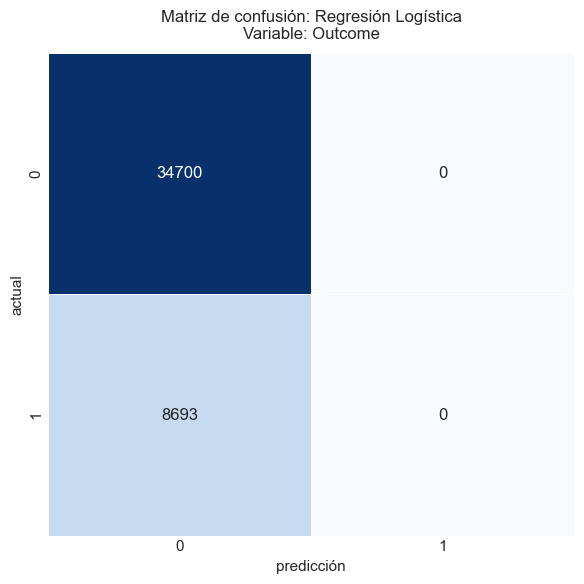

In [28]:
# === Matriz de confusión visual (estilo ejemplo) — LOGÍSTICO ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_logit, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Regresión Logística\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


1) Qué muestra:
La figura presenta la matriz de confusión correspondiente al modelo regresion lineal aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones
2) Hallazgo principal:
Lo que podemos ver es que el modelo solo pudo predecir la clase 0, ya que el único campo dentro de la matriz de confusión lleno fue verdadero negativo = 34,700 y falso negativo = 8693, esta es la razón por la que nuestra precisión es tan alta en 0.7997 y, sin embargo, nuestro falso positivo y verdadero positivo son ambos 0, lo que no refleja eso, además de que tanto el recall como el f1 score también son 0 para la clase 0, lo que hace que nuestro accuracy no sea tan confiable.
3) Interpretación:
Lo que podemos obtener de estos resultados es que el modelo desarrolló un fuerte sesgo hacia la clase mayoritaria, probablemente debido al desequilibrio de clases o a la escasa separabilidad de las mismas. La regresión logística minimiza el error general, por lo que favorece la predicción de la clase dominante para mantener bajos los errores totales.
4) Implicación:
El modelo necesita técnicas de equilibrio como SMOTE o submuestreo o ajuste de umbral para mejorar la detección de clase 1.
5) Limitaciones:
La matriz revela un sobreajuste a la clase dominante y una generalización deficiente. El tamaño desigual de las clases también hace que la estimación de probabilidad sea poco fiable.

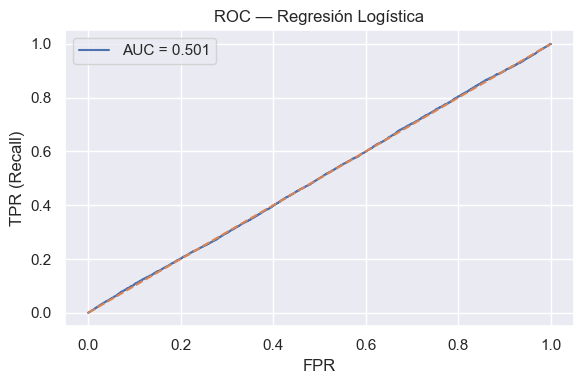

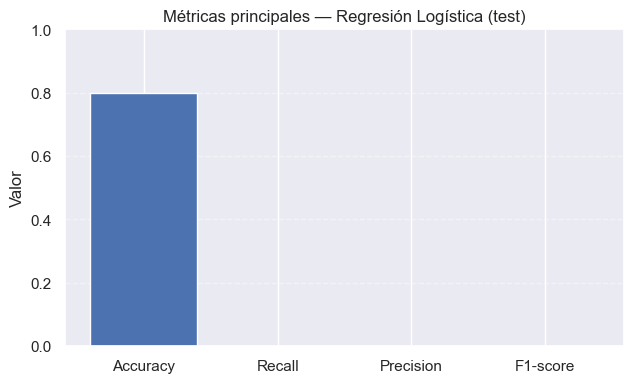

In [29]:
# === ROC/AUC (binario) + barras de métricas clave — LOGÍSTICO ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC/AUC si binario
if len(np.unique(y_test)) == 2 and scores_te is not None:
    pos_label = max(np.unique(y_test))
    fpr, tpr, thr = roc_curve(y_test, scores_te, pos_label=pos_label)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores_te):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — Regresión Logística")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) en test
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
avg = "binary" if len(np.unique(y_test))==2 else "weighted"
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_logit),
    "Recall":    recall_score(y_test, y_pred_logit, average=avg, zero_division=0),
    "Precision": precision_score(y_test, y_pred_logit, average=avg, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_logit, average=avg, zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — Regresión Logística (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Roc -- Regresion logistico
1) Qué muestra:
La graphica es la del curva ded Roc que en este caso esta evalúando el modelo regresion logistica en la variable de outcome utilizando datos de prueba. Tiene un AUC = 0,501.

2) Hallazgo principal:
Con un valor de AUC cercano a 0,5 esto nos indica que el modelo no funciona mejor que una suposición aleatoria. Esto confirma que el modelo de regresion logistico no distingue eficazmente entre clases positivas y negativas.

3) Interpretación:
Las probabilidades predichas son casi constantes, por lo que el modelo no puede separar las dos clases. Esto puede ocurrir cuando no existe una relación sólida entre la característica y la clase, existe una alta multicolinealidad o características sin escalar que afectan la optimización.

4) Implicación:
El modelo requiere una mejor ingeniería de características o normalización de la entrada. Ajustar el umbral de decisión no servirá de nada, ya que la distribución de puntuaciones no tiene separación.

5) Limitaciones:
Debido a que el AUC es tan bajo, dificulta la evaluación del sobreajuste. Además, debido al probable desequilibrio del conjunto de datos y a la probable escasez de características relevantes, se limita la capacidad de aprendizaje del modelo.


Metricas principales -- regresion Logistico
1) Qué muestra:
Este gráfico de barras resume las principales métricas de rendimiento: accuracy = 0,7997, recall = 0,0, Precisión = 0,0 y F1 = 0,0 en los datos de prueba.
2) Hallazgo principal:
Si bien muestra que la precisión es alta con todas las demás variables de recuperación, precisión y f1 siendo 0, sabemos que nuestra precisión no es muy confiable.
3) Interpretación:
El desequilibrio hace que el modelo favorezca a la clase mayoritaria. La función de pérdida en la regresión logística, sin ponderación de clase, minimiza los errores generales al ignorar por completo los resultados de las minorías. Por lo tanto, presenta una recuperación y una precisión nulas para la clase 1.
4) Implicación:
Para predicciones futuras, el modelo debe volver a entrenarse con pesos de clase equilibrados, realizar un remuestreo adicional o probar otro modelo.
5) Limitaciones:
La precisión oculta una detección deficiente de minorías. Un conjunto de datos pequeño o desequilibrado puede impedir una evaluación justa. Los análisis futuros deberían incluir métricas por clase o curvas PR para obtener una visión más realista del rendimiento del modelo.

# Naive Bayes

In [30]:
# === NAIVE BAYES (GaussianNB) en Pipeline ===
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import numpy as np

nb = GaussianNB()  # apropiado para variables continuas tras el preprocess

pipe_nb = Pipeline([
    ("prep", preprocess),   # reutiliza tu preprocess de la Parte 1
    ("clf", nb),
])

pipe_nb.fit(X_train, y_train)
y_pred_nb = pipe_nb.predict(X_test)

# Probabilidades (para métricas y ROC si binario)
# Nota: GaussianNB siempre expone predict_proba
if len(np.unique(y_test)) == 2:
    # prob. de la clase positiva (tomamos la mayor etiqueta como positiva)
    pos_label = max(np.unique(y_test))
    clases_clf = list(pipe_nb.named_steps["clf"].classes_)
    y_proba_nb = pipe_nb.predict_proba(X_test)[:, clases_clf.index(pos_label)]
    scores_te = y_proba_nb.copy()
else:
    y_proba_nb = pipe_nb.predict_proba(X_test)
    scores_te = None
# ====== FIN NAIVE BAYES ======

In [31]:
# === NAIVE BAYES (GaussianNB) en Pipeline ===
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import numpy as np

nb = GaussianNB()  # apropiado para variables continuas tras el preprocess

pipe_nb = Pipeline([
    ("prep", preprocess),   # reutiliza tu preprocess de la Parte 1
    ("clf", nb),
])

pipe_nb.fit(X_train, y_train)
y_pred_nb = pipe_nb.predict(X_test)

# Probabilidades (para métricas y ROC si binario)
# Nota: GaussianNB siempre expone predict_proba
if len(np.unique(y_test)) == 2:
    # prob. de la clase positiva (tomamos la mayor etiqueta como positiva)
    pos_label = max(np.unique(y_test))
    clases_clf = list(pipe_nb.named_steps["clf"].classes_)
    y_proba_nb = pipe_nb.predict_proba(X_test)[:, clases_clf.index(pos_label)]
    scores_te = y_proba_nb.copy()
else:
    y_proba_nb = pipe_nb.predict_proba(X_test)
    scores_te = None


In [32]:
# === Evaluación — NAIVE BAYES (GaussianNB) ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (Naive Bayes):", round(accuracy_score(y_test, y_pred_nb), 4))
print("\nReporte de clasificación (Naive Bayes):\n",
      classification_report(y_test, y_pred_nb, zero_division=0))

# Matriz de confusión explicativa
cm = confusion_matrix(y_test, y_pred_nb)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# AUC si binario y tenemos scores (probabilidades)
clases = np.unique(y_test)
if len(clases) == 2 and scores_te is not None:
    auc = roc_auc_score(y_test, scores_te)
    print(f"AUC (Naive Bayes): {auc:.4f}")


Accuracy (Naive Bayes): 0.7997

Reporte de clasificación (Naive Bayes):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     34700
           1       0.00      0.00      0.00      8693

    accuracy                           0.80     43393
   macro avg       0.40      0.50      0.44     43393
weighted avg       0.64      0.80      0.71     43393



,Pred 0,Pred 1
Real 0,34700,0
Real 1,8693,0


AUC (Naive Bayes): 0.4974


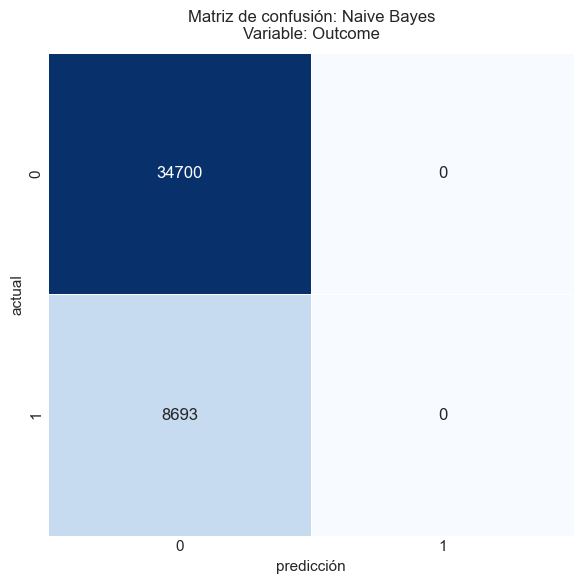

In [33]:
# === Matriz de confusión visual (estilo ejemplo) — NAIVE BAYES ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_nb, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Naive Bayes\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


1) Qué muestra:
La figura presenta la matriz de confusión correspondiente al modelo naive bayes Gaussian aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones
2) Hallazgo principal:
Lo que podemos ver es que el modelo solo pudo predecir la clase 0, ya que el único campo dentro de la matriz de confusión lleno fue verdadero negativo = 34,700 y falso negativo = 8693, esta es la razón por la que nuestra precisión es tan alta en 0.7997 y, sin embargo, nuestro falso positivo y verdadero positivo son ambos 0, lo que no refleja eso, además de que tanto el recall como el f1 score también son 0 para la clase 0, lo que hace que nuestro accuracy no sea tan confiable.
3) Interpretación:
Lo que podemos obtener de estos resultados es que el modelo desarrolló un fuerte sesgo hacia la clase mayoritaria, probablemente debido al desequilibrio de clases o a la escasa separabilidad de las mismas. El método naive bayes asume la independencia de las características, y las distribuciones gaussianas suelen fallar cuando las características están correlacionadas o no se distribuyen normalmente. Si la clase minoritaria tiene distribuciones de características superpuestas o no diferenciadas, el método Bayesiano ingenuo le asigna probabilidades posteriores bajas, optando siempre por la clase mayoritaria. Esto es lo que podría estar sucediendo aquí.
4) Implicación:
El modelo necesita técnicas de equilibrio como SMOTE o submuestreo o remuestreo mejorar la detección de clase 1.
5) Limitaciones:
La matriz de confusión refleja un sesgo extremo y una generalización deficiente.Los supuestos de Naive Bayes la hacen inadecuada para espacios de características altamente desequilibrados o correlacionados, y no permite adaptar los umbrales de forma significativa.

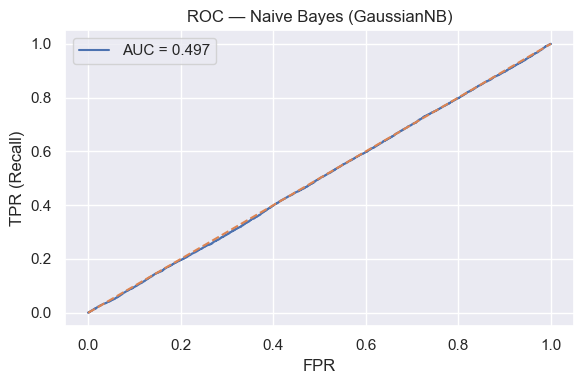

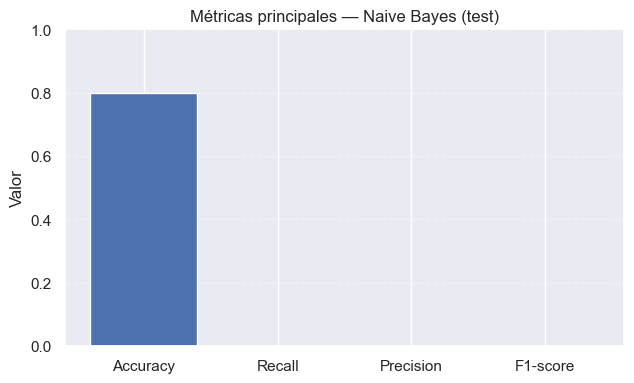

In [34]:
# === ROC/AUC (binario) + barras de métricas clave — NAIVE BAYES ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# ROC/AUC si binario
if len(np.unique(y_test)) == 2 and scores_te is not None:
    pos_label = max(np.unique(y_test))
    fpr, tpr, thr = roc_curve(y_test, scores_te, pos_label=pos_label)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores_te):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — Naive Bayes (GaussianNB)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) en test
avg = "binary" if len(np.unique(y_test))==2 else "weighted"
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_nb),
    "Recall":    recall_score(y_test, y_pred_nb, average=avg, zero_division=0),
    "Precision": precision_score(y_test, y_pred_nb, average=avg, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_nb, average=avg, zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — Naive Bayes (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Roc -- Naive bayes Gaussian
1) Qué muestra:
La graphica es la del curva ded Roc que en este caso esta evalúando el modelo regresion logistica en la variable de outcome utilizando datos de prueba. Tiene un AUC = 0,497.

2) Hallazgo principal:
Con un valor de AUC cercano a 0,5 esto nos indica que el modelo no funciona mejor que una suposición aleatoria. Esto confirma que el modelo de Naive bayes Gaussian no distingue eficazmente entre clases positivas y negativas.

3) Interpretación:
Dado que el AUC es tan deficiente, se obtienen resultados de distribuciones gaussianas superpuestas de características entre ambas clases. Esto se debe a que el método Naive bayes asume que cada característica sigue una distribución normal condicionada a la clase; sin embargo, cuando esto no es cierto, las estimaciones de probabilidad se vuelven poco fiables. Por lo tanto, el modelo produce probabilidades casi idénticas para todas las muestras, lo que da como resultado una línea ROC prácticamente aleatoria.

4) Implicación:
El modelo requiere una mejor ingeniería de características o normalización de la entrada. Ajustar el umbral de decisión no servirá de nada, ya que la distribución de puntuaciones no tiene separación.

5) Limitaciones:
El método Bayes ingenuo falla cuando las suposiciones gaussianas no se cumplen o cuando las clases no están bien separadas en el espacio de características. El bajo AUC muestra su falta de robustez y su incapacidad para aprender límites complejos.


Metricas principales -- Naive Bayes Gaussian
1) Qué muestra:
Este gráfico de barras resume las principales métricas de rendimiento: accuracy = 0,7997, recall = 0,0, Precisión = 0,0 y F1 = 0,0 en los datos de prueba.
2) Hallazgo principal:
Si bien muestra que la precisión es alta con todas las demás variables de recuperación, precisión y f1 siendo 0, sabemos que nuestra precisión no es muy confiable.
3) Interpretación:
Este patrón se produce porque el método Bayes ingenuo se basa en gran medida en las probabilidades previas (P(Clase)) y las verosimilitudes de las características (P(X|Clase)).Cuando una clase predomina, su probabilidad previa sobrepasa el cálculo de la probabilidad posterior, lo que provoca una predicción sistemática de la clase mayoritaria. Además, las características correlacionadas o sesgadas violan el supuesto de independencia, lo que reduce su fiabilidad.
4) Implicación:
La precisión no debe utilizarse únicamente con el desequilibrio de clases lo hace irrelevante. Para mejorar el rendimiento, el modelo podría reentrenarse con valores previos balanceados, transformaciones logarítmicas o características con varianza estabilizada para ajustarse mejor a los supuestos gaussianos.
5) Limitaciones:
La simplicidad del modelo Naive Bayes lo hace computacionalmente eficiente, pero estadísticamente rígido. No maneja adecuadamente datos correlacionados, no gaussianos o desequilibrados, lo que genera métricas engañosas y una capacidad de aprendizaje limitada.

In [35]:
# === MÉTRICAS COMPLETAS — NAIVE BAYES (GaussianNB) ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, matthews_corrcoef
)

# --- Configurar etiqueta positiva ---
classes = np.unique(y_test)
pos_label = 1 if 1 in classes else classes.max()

def binariza(y, pos):
    y = pd.Series(y).values
    return (y == pos).astype(int)

# --- Confusion matrix (multiclase y binario) ---
cm = confusion_matrix(y_test, y_pred_nb, labels=classes)
cm_df = pd.DataFrame(cm,
                     index=[f"Real {c}" for c in classes],
                     columns=[f"Pred {c}" for c in classes])
print("Matriz de confusión (Naive Bayes):")
display(cm_df)

# --- Métricas por clase y promedios (macro/weighted) ---
print("\nReporte de clasificación (Naive Bayes):")
rep_dict = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_dict).T.style.format("{:.4f}"))

# --- Métricas binarias principales para la clase positiva (pos_label) ---
y_true_bin = binariza(y_test, pos_label)
y_pred_bin = binariza(y_pred_nb, pos_label)

tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
total = tn + fp + fn + tp

acc   = accuracy_score(y_true_bin, y_pred_bin)
error = 1 - acc
tpr   = tp / (tp + fn) if (tp + fn)>0 else 0.0     # Recall / Sensibilidad
fpr   = fp / (fp + tn) if (fp + tn)>0 else 0.0
tnr   = tn / (tn + fp) if (tn + fp)>0 else 0.0     # Especificidad
ppv   = precision_score(y_true_bin, y_pred_bin, zero_division=0)  # Precisión
npv   = tn / (tn + fn) if (tn + fn)>0 else 0.0
f1    = f1_score(y_true_bin, y_pred_bin, zero_division=0)
prev  = (tp + fn) / total if total>0 else 0.0
bacc  = (tpr + tnr) / 2
mcc   = matthews_corrcoef(y_true_bin, y_pred_bin) if total>0 else 0.0

# AUC con scores continuos si están disponibles (binario)
auc = None
if scores_te is not None:
    try:
        auc = roc_auc_score(y_true_bin, scores_te)
    except Exception:
        auc = None

# --- Tabla resumen ejecutiva ---
resumen = pd.DataFrame([
    ("Accuracy",                 acc),
    ("Error (1-Acc)",            error),
    ("TPR / Recall",             tpr),
    ("FPR",                      fpr),
    ("Especificidad (TNR)",      tnr),
    ("Precision (PPV)",          ppv),
    ("NPV",                      npv),
    ("F1-score",                 f1),
    ("Prevalencia P(Y=1)",       prev),
    ("Balanced Accuracy",        bacc),
    ("MCC",                      mcc),
    ("AUC (si hay scores)",      auc),
], columns=["Métrica", "Valor"])

print(f"\nClase positiva considerada: {pos_label}")
display(resumen.style.format({"Valor": lambda v: "—" if v is None else f"{v:.4f}"}).hide(axis="index"))


Matriz de confusión (Naive Bayes):


,Pred 0,Pred 1
Real 0,34700,0
Real 1,8693,0



Reporte de clasificación (Naive Bayes):


,precision,recall,f1-score,support
0,0.7997,1.0000,0.8887,34700.0000
1,0.0000,0.0000,0.0000,8693.0000
accuracy,0.7997,0.7997,0.7997,0.7997
macro avg,0.3998,0.5000,0.4443,43393.0000
weighted avg,0.6395,0.7997,0.7107,43393.0000



Clase positiva considerada: 1


Métrica,Valor
Accuracy,0.7997
Error (1-Acc),0.2003
TPR / Recall,0.0000
FPR,0.0000
Especificidad (TNR),1.0000
Precision (PPV),0.0000
NPV,0.7997
F1-score,0.0000
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.5000


# Árbol de decisiones


In [36]:
# === ÁRBOL DE DECISIÓN en Pipeline ===
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import numpy as np

tree = DecisionTreeClassifier(
    criterion="gini",     # puedes cambiar a "entropy" o "log_loss"
    max_depth=None,       # ajusta si hay overfitting (p.ej., 5-20)
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
    # , class_weight="balanced"  # <-- descomenta si hay desbalance fuerte
)

pipe_tree = Pipeline([
    ("prep", preprocess),   # reutiliza tu preprocess de la Parte 1
    ("clf", tree),
])

pipe_tree.fit(X_train, y_train)
y_pred_tree = pipe_tree.predict(X_test)

# Probabilidades (para métricas y ROC si binario)
if len(np.unique(y_test)) == 2:
    pos_label = max(np.unique(y_test))
    clases_clf = list(pipe_tree.named_steps["clf"].classes_)
    y_proba_tree = pipe_tree.predict_proba(X_test)[:, clases_clf.index(pos_label)]
    scores_te = y_proba_tree.copy()   # para ROC/AUC en Partes 6/7
else:
    y_proba_tree = pipe_tree.predict_proba(X_test)
    scores_te = None
# ====== FIN ÁRBOL DE DECISIÓN ======

In [37]:
# === Evaluación — ÁRBOL DE DECISIÓN ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (Árbol):", round(accuracy_score(y_test, y_pred_tree), 4))
print("\nReporte de clasificación (Árbol):\n",
      classification_report(y_test, y_pred_tree, zero_division=0))

# Matriz de confusión explicativa
cm = confusion_matrix(y_test, y_pred_tree)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# AUC si binario y tenemos scores (probabilidades)
clases = np.unique(y_test)
if len(clases) == 2 and scores_te is not None:
    auc = roc_auc_score(y_test, scores_te)
    print(f"AUC (Árbol): {auc:.4f}")


Accuracy (Árbol): 0.6685

Reporte de clasificación (Árbol):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     34700
           1       0.20      0.22      0.21      8693

    accuracy                           0.67     43393
   macro avg       0.50      0.50      0.50     43393
weighted avg       0.68      0.67      0.67     43393



,Pred 0,Pred 1
Real 0,27128,7572
Real 1,6813,1880


AUC (Árbol): 0.4993


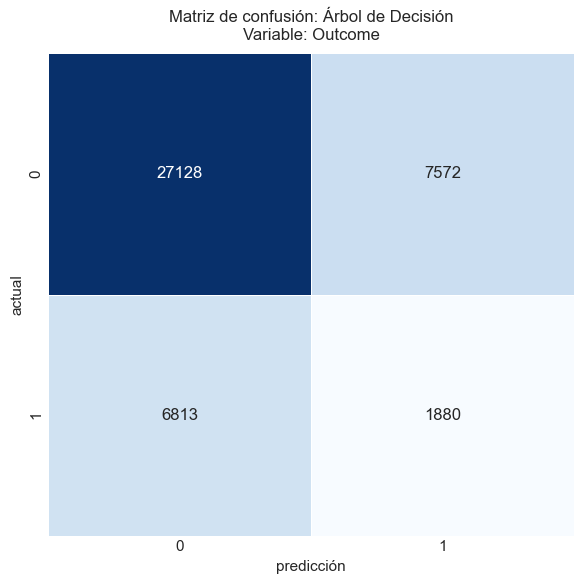

In [38]:
# === Matriz de confusión visual (estilo ejemplo) — ÁRBOL DE DECISIÓN ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_tree, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Árbol de Decisión\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


1) Qué muestra:
La figura presenta la matriz de confusión correspondiente al modelo Arbol de decisciones aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones

2) Hallazgo principal:
El modelo logró una precisión de 0,6685, lo cual es bastante alto y este valor parece ser confiable, ya que obtuvimos 27 128 verdaderos negativos y 7572 verdaderos positivos. Sin embargo, observamos un sesgo hacia la clase 0, ya que representa el 80 % de las predicciones del modelo, debido a la alta cantidad de falsos negativos (6813) en comparación con los 1880 falsos positivos. Esto se ve respaldado por los bajos niveles de recall y la  F1 score para la clase 1, con una recall de 0,22 y f1 de 0,21, lo que significa que se predice una proporción muy baja de la clase 1.

3) Interpretación:
El árbol tiene dificultades para identificar correctamente las muestras minoritarias porque se divide en función de la impureza general (Gini/Entropía), que está dominada por la clase mayoritaria.
Este desequilibrio hace que el árbol favorezca los nodos que mejoran la precisión de la mayoría, pero no logran aislar las instancias minoritarias. Además, las ramas superficiales o sobreajustadas pueden memorizar los datos de entrenamiento sin aprender reglas generalizables.

4) Implicación:
La matriz de confusión indica la necesidad de ponderar la clase o realizar un muestreo equilibrado durante el entrenamiento. Como alternativa, el uso de variantes de conjunto podría ayudar a capturar límites más complejos y reducir el sesgo hacia la clase mayoritaria.

5) Limitaciones:
Los árboles de decisión son sensibles al desequilibrio de clases y a las características ruidosas. Sin poda ni balanceo, corren el riesgo de sobreajustar los patrones mayoritarios y tener un rendimiento inferior en la detección de minorías.


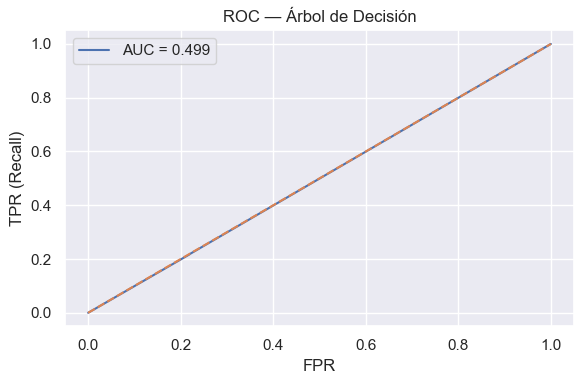

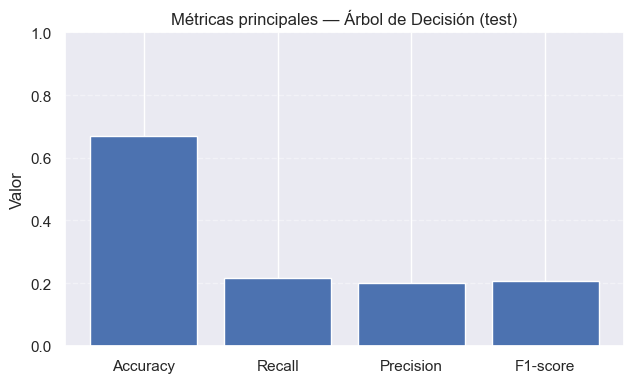

In [39]:
# === ROC/AUC (binario) + barras de métricas clave — ÁRBOL DE DECISIÓN ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# ROC/AUC si binario
if len(np.unique(y_test)) == 2 and scores_te is not None:
    pos_label = max(np.unique(y_test))
    fpr, tpr, thr = roc_curve(y_test, scores_te, pos_label=pos_label)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores_te):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — Árbol de Decisión")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) en test
avg = "binary" if len(np.unique(y_test))==2 else "weighted"
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_tree),
    "Recall":    recall_score(y_test, y_pred_tree, average=avg, zero_division=0),
    "Precision": precision_score(y_test, y_pred_tree, average=avg, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_tree, average=avg, zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — Árbol de Decisión (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


ROC -- Arbol de decisciones
1) Qué muestra:
La graphica es la del curva ded Roc que en este caso esta evalúando el modelo Arbol de decisciones en la variable de outcome utilizando datos de prueba. Tiene un AUC = 0.499.

2) Hallazgo principal:
La curva ROC es casi diagonal, con un AUC de 0,4993, lo que indica un rendimiento no mejor que el aleatorio. Esto sugiere que los resultados de probabilidad del modelo ofrecen poca o ninguna separación entre clases.

3) Interpretación:
Una ROC casi aleatoria se produce cuando las probabilidades predichas del árbol, derivadas de las proporciones de las clases de hojas, están mal calibradas o no son distintas entre clases.
Esto puede ocurrir cuando el árbol se sobreajusta o se infraajusta, especialmente si muchas hojas contienen muestras de clases mixtas. En este conjunto de datos, la superposición de características de clase y el desequilibrio reducen aún más la capacidad del modelo para generar probabilidades significativas.

4) Implicación:
El umbral del modelo no se puede ajustar eficazmente, ya que no hay una señal clara en las probabilidades predichas.Los enfoques futuros deberían incluir la ingeniería de características, el muestreo equilibrado o el uso de conjuntos que promedien múltiples árboles para estabilizar las estimaciones de probabilidad.

5) Limitaciones:
Un AUC cual aporximada mente 0,5 muestra que, si bien el modelo clasifica la clase mayoritaria razonablemente bien, no logra aprender una separación significativa de clases.
Los árboles de decisión por sí solos son inestables y sensibles al ruido, especialmente con muchas variables correlacionadas o no informativas.

Metricas principales -- Arbol de decisciones
1) Qué muestra:
Este gráfico de barras resume las principales métricas de rendimiento: accuracy = 0.6685, recall = 0.2163, Precisión = 0.1989 y F1 = 0.2072 en los datos de prueba.

2) Hallazgo principal:
Podemos ver que, si bien la precisión general es moderada, el desempeño de la clase minoritaria es débil ya que todos los valores de las variables son muy bajos, lo que se refleja en que el modelo predice la clase mayoritaria correctamente la mayor parte del tiempo, pero omite muchos casos minoritarios.

3) Interpretación:
El árbol de decisión captura los patrones dominantes de la clase mayoritaria, pero no generaliza el comportamiento de la minoría. Esto puede deberse a un desequilibrio de clases, una poda insuficiente o divisiones dominadas por etiquetas de alta frecuencia. La baja puntuación F1 refleja un equilibrio deficiente entre precisión y recuperación, por lo que el modelo rara vez identifica los positivos y, cuando lo hace, muchos son falsas alarmas.

4) Implicación:
Para predicciones futuras, el modelo debe volver a entrenarse con pesos de clase equilibrados, realizar un remuestreo adicional o probar otro modelo.

5) Limitaciones:
Los árboles de decisión únicos pueden ser muy variables y propensos a sesgos cuando las distribuciones de clases están sesgadas. Sin regularización, pueden memorizar patrones de datos de entrenamiento que no se generalizan a los conjuntos de prueba.

In [40]:
# === MÉTRICAS COMPLETAS — ÁRBOL DE DECISIÓN ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, matthews_corrcoef
)

# --- Configurar etiqueta positiva ---
classes = np.unique(y_test)
pos_label = 1 if 1 in classes else classes.max()

def binariza(y, pos):
    y = pd.Series(y).values
    return (y == pos).astype(int)

# --- Confusion matrix (multiclase y binario) ---
cm = confusion_matrix(y_test, y_pred_tree, labels=classes)
cm_df = pd.DataFrame(cm,
                     index=[f"Real {c}" for c in classes],
                     columns=[f"Pred {c}" for c in classes])
print("Matriz de confusión (Árbol de Decisión):")
display(cm_df)

# --- Métricas por clase y promedios (macro/weighted) ---
print("\nReporte de clasificación (Árbol de Decisión):")
rep_dict = classification_report(y_test, y_pred_tree, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_dict).T.style.format("{:.4f}"))

# --- Métricas binarias principales para la clase positiva (pos_label) ---
y_true_bin = binariza(y_test, pos_label)
y_pred_bin = binariza(y_pred_tree, pos_label)

tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
total = tn + fp + fn + tp

acc   = accuracy_score(y_true_bin, y_pred_bin)
error = 1 - acc
tpr   = tp / (tp + fn) if (tp + fn)>0 else 0.0     # Recall / Sensibilidad
fpr   = fp / (fp + tn) if (fp + tn)>0 else 0.0
tnr   = tn / (tn + fp) if (tn + fp)>0 else 0.0     # Especificidad
ppv   = precision_score(y_true_bin, y_pred_bin, zero_division=0)  # Precisión
npv   = tn / (tn + fn) if (tn + fn)>0 else 0.0
f1    = f1_score(y_true_bin, y_pred_bin, zero_division=0)
prev  = (tp + fn) / total if total>0 else 0.0
bacc  = (tpr + tnr) / 2
mcc   = matthews_corrcoef(y_true_bin, y_pred_bin) if total>0 else 0.0

# AUC con scores continuos si están disponibles (binario)
auc = None
if scores_te is not None:
    try:
        auc = roc_auc_score(y_true_bin, scores_te)
    except Exception:
        auc = None

# --- Tabla resumen ejecutiva ---
resumen = pd.DataFrame([
    ("Accuracy",                 acc),
    ("Error (1-Acc)",            error),
    ("TPR / Recall",             tpr),
    ("FPR",                      fpr),
    ("Especificidad (TNR)",      tnr),
    ("Precision (PPV)",          ppv),
    ("NPV",                      npv),
    ("F1-score",                 f1),
    ("Prevalencia P(Y=1)",       prev),
    ("Balanced Accuracy",        bacc),
    ("MCC",                      mcc),
    ("AUC (si hay scores)",      auc),
], columns=["Métrica", "Valor"])

print(f"\nClase positiva considerada: {pos_label}")
display(resumen.style.format({"Valor": lambda v: "—" if v is None else f"{v:.4f}"}).hide(axis="index"))

# --- Importancias de variables (feature importance) ---
try:
    feat_names = pipe_tree.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names = [f"feat_{i}" for i in range(pipe_tree.named_steps["prep"].transform(X_train).shape[1])]

importancias = pipe_tree.named_steps["clf"].feature_importances_
fi_df = pd.DataFrame({"feature": feat_names, "importance": importancias}) \
        .sort_values("importance", ascending=False)

display(fi_df.head(20))


Matriz de confusión (Árbol de Decisión):


,Pred 0,Pred 1
Real 0,27128,7572
Real 1,6813,1880



Reporte de clasificación (Árbol de Decisión):


,precision,recall,f1-score,support
0,0.7993,0.7818,0.7904,34700.0000
1,0.1989,0.2163,0.2072,8693.0000
accuracy,0.6685,0.6685,0.6685,0.6685
macro avg,0.4991,0.4990,0.4988,43393.0000
weighted avg,0.6790,0.6685,0.6736,43393.0000



Clase positiva considerada: 1


Métrica,Valor
Accuracy,0.6685
Error (1-Acc),0.3315
TPR / Recall,0.2163
FPR,0.2182
Especificidad (TNR),0.7818
Precision (PPV),0.1989
NPV,0.7993
F1-score,0.2072
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.4990


,feature,importance
8,num__StressLevel,0.463659
1,num__Glucose,0.050611
6,num__DiabetesPedigreeFunction,0.045107
5,num__BMI,0.043614
2,num__BloodPressure,0.034754
13,num__HighCarb,0.031047
7,num__Age,0.030342
12,num__Balanced,0.030129
3,num__SkinThickness,0.029851
14,num__LowCarb,0.029537
